In [27]:
import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

from rlptx.environment.weather import WeatherDataProvider
from rlptx.environment.environment import PtxEnvironment
from rlptx.ptx import load_project
from rlptx.logger import disable_logger
from rlptx.evaluation.visualization import plot_log
from rlptx.evaluation.core import load_log

disable_logger("main")
disable_logger("status")
disable_logger("reward")
disable_logger("episode")

## Exploration

Show some interesting data and numbers of the case study

In [28]:
# Weather data overview
weather = WeatherDataProvider()
w_len = weather.weather_data_joined.shape[0]
wtr_len = weather.weather_data_train.shape[0]
wte_len = weather.weather_data_test.shape[0]
print(f"Data amount: {w_len}, Train amount: {wtr_len}, Test amount: {wte_len}")
print(f"In days: Data amount: {int(w_len/24)}, Train amount: {wtr_len/24}, Test amount: {wte_len/24}")
start_train = weather.weather_data_train["time"].iloc[0].date()
end_train = weather.weather_data_train["time"].iloc[-1].date()
start_test = weather.weather_data_test["time"].iloc[0].date()
end_test = weather.weather_data_test["time"].iloc[-1].date()
print(f"Train period: {start_train} - {end_train}, Test period: {start_test} - {end_test}")

Data amount: 359424, Train amount: 323481, Test amount: 35943
In days: Data amount: 14976, Train amount: 13478.375, Test amount: 1497.625
Train period: 1980-01-01 - 2016-11-25, Test period: 2016-11-25 - 2020-12-31


In [29]:
# PtX system configuration overview
ptx_system = load_project(config_file='not_robust_FT_all_data_no_scaling.yaml')
env = PtxEnvironment(ptx_system, weather)
print(f"Observation space size: {env.observation_space_size}, Action space size: {env.action_space_size}")
print("\nObservations (Element, Attributes):")
for k, v in env.observation_space_info.items():
    v = str(v)[1:-1].replace("\'", "")
    print(f"{k}: {v}")
print("\nActions (Element, Action, Low, High):")
actions = []
for k, v in env.action_space_info.items():
    if v is None or v == []:
        continue
    actions.append((k, v))
for a, l, h in zip(actions, env.action_space_spec["low"], env.action_space_spec["high"]):
    print(f"{a[0]}: {str(*a[1])} [{l}, {h}]")

Observation space size: 126, Action space size: 12

Observations (Element, Attributes):
environment: current_day, current_hour, current_Solar, current_Wind, day1_hour0_Solar, day1_hour0_Wind, day1_hour1_Solar, day1_hour1_Wind, day1_hour2_Solar, day1_hour2_Wind, day1_hour3_Solar, day1_hour3_Wind, day1_hour4_Solar, day1_hour4_Wind, day1_hour5_Solar, day1_hour5_Wind, day1_hour6_Solar, day1_hour6_Wind, day1_hour7_Solar, day1_hour7_Wind, day1_hour8_Solar, day1_hour8_Wind, day1_hour9_Solar, day1_hour9_Wind, day1_hour10_Solar, day1_hour10_Wind, day1_hour11_Solar, day1_hour11_Wind, day1_hour12_Solar, day1_hour12_Wind, day1_hour13_Solar, day1_hour13_Wind, day1_hour14_Solar, day1_hour14_Wind, day1_hour15_Solar, day1_hour15_Wind, day1_hour16_Solar, day1_hour16_Wind, day1_hour17_Solar, day1_hour17_Wind, day1_hour18_Solar, day1_hour18_Wind, day1_hour19_Solar, day1_hour19_Wind, day1_hour20_Solar, day1_hour20_Wind, day1_hour21_Solar, day1_hour21_Wind, day1_hour22_Solar, day1_hour22_Wind, day1_hour23_

In [32]:
# Impact of low electricity availability on PtX system
ptx_system2 = load_project(config_file='not_robust_FT_all_data_no_scaling.yaml')
conversions = ptx_system2.get_conversion_components_objects()
generators = ptx_system2.get_generator_components_objects()
for c in conversions:
    if c.name in ["H2 Compressor", "H2 Decompressor"]: # not needed in minimal runnable config
        c.load = c.min_p # set to minimum possible load
    else:
        c.load = c.max_p # set all relevant components to maximum possible load
for g in generators:
    g.curtailment = g.fixed_capacity # disable generators
env2 = PtxEnvironment(ptx_system2, weather)
env2.initialize()

# iteratively find out how much loads of conversions can be reduced before system fails
# ignore electricity and water by providing sufficient amounts
decrease = 0.01
max_reduction = decrease
while True:
    env2.ptx_system.commodities["Electricity"].available_quantity = 99999
    env2.ptx_system.commodities["Water"].available_quantity = 99999
    _, _, terminated, _, _ = env2.act(
        [0, 0, 0, 0, -decrease, -decrease, 0, 0, -decrease, -decrease, 0, 0]
    )
    if terminated:
        env2.reset()
        break
    max_reduction += decrease
print("Max amount load of conversions can be reduced before system fails:", round(max_reduction, 4))

# iteratively find out how much generation quantity of generators can be reduced before system fails
for c in env2.ptx_system.get_conversion_components_objects():
    if c.name not in ["H2 Compressor", "H2 Decompressor"]: # not needed in minimal runnable config
        c.load = max(c.min_p, c.load - max_reduction + decrease) # set conversions to minimum possible load
avail_elec = sum([g.fixed_capacity for g in generators]) # start with max electricity that could be generated
print("Max potential electricity generation amount:", round(avail_elec, 4))
while True:
    env2.ptx_system.commodities["Electricity"].available_quantity = avail_elec
    env2.ptx_system.commodities["Water"].available_quantity = 99999
    _, _, terminated, _, _ = env2.act(
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )
    if terminated:
        break
    avail_elec -= 1
print("Min possible electricity generation amount before system fails:", round(avail_elec, 4))

# get periods with less available energy than min necessary electricity
weather_data = weather.weather_data_joined
periods = []
period_len = 0
is_period = False
for i in range(len(weather_data)):
    generated = sum([g.fixed_capacity * weather_data[g.name][i] for g in generators])
    if generated < avail_elec:
        is_period = True
        period_len += 1
    else:
        if is_period:
            periods.append(period_len)
            is_period = False
        period_len = 0
print("Insufficient energy period lengths (first 30):", sorted(periods, reverse=True)[:30])
print("Insufficient energy periods longer than 1 day: {}, 2 days: {}, 3 days: {}".format(
    len([v for v in periods if v > 24]), len([v for v in periods if v > 48]), len([v for v in periods if v > 72])
))
p = sns.displot(periods, binwidth=1, facet_kws={"subplot_kws": {"yscale": "log"}}, color="#00C1A7", aspect=1.5)
p = p.set_axis_labels("Period length", "Frequency", fontsize=16)
_ = p.tick_params(labelsize=16)

Max amount load of conversions can be reduced before system fails: 0.3
Max potential electricity generation amount: 2040.7857
Min possible electricity generation amount before system fails: 400.7857
Insufficient energy period lengths (first 30): [86, 69, 67, 66, 65, 53, 47, 46, 45, 45, 44, 44, 44, 44, 44, 43, 43, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 42, 42, 41]
Insufficient energy periods longer than 1 day: 76, 2 days: 6, 3 days: 1


## Evaluation

Show results of training runs. All data is shown with the value for each episode on the y-axis and all episodes on the x-axis.

#### Using reward function with revenue reward and leftover commodity penalty to maximize revenue

##### Training

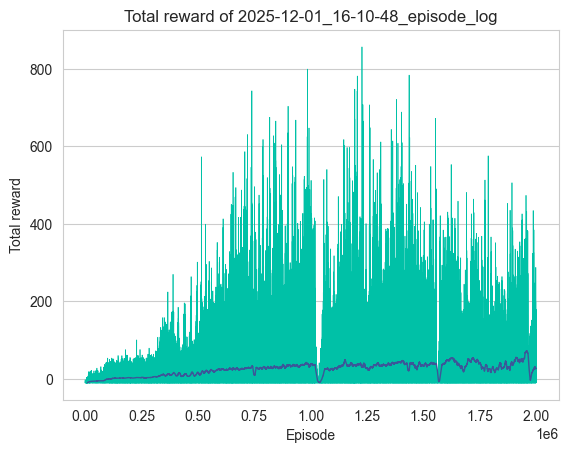

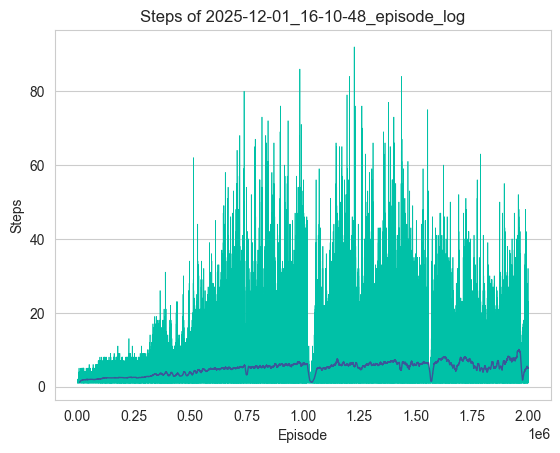

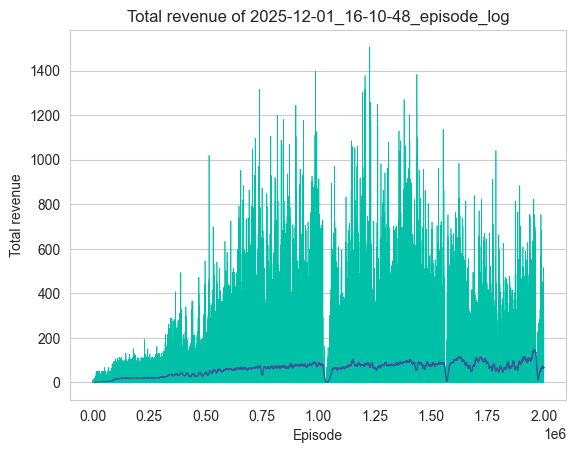

In [2]:
# Plot training performance in PtX environment (reward, revenue, and steps per episode)
plot_log(filename="2025-12-01_16-10-48_episode_log")

In [25]:
train_episode_df = load_log("2025-12-01_16-10-48_episode_log")
train_episode_df.describe()

Total reward  Reward/Step        Steps  Total revenue
count  2000000.0000 2000000.0000 2000000.0000   2000000.0000
mean        25.3501       2.5067       4.9042        60.5203
std         37.6323       4.7199       4.0802        67.2737
min        -10.0800     -10.0000       1.0000        -2.4507
25%         -0.4482      -0.2241       2.0000        14.1529
50%         13.5204       3.3727       4.0000        38.5234
75%         35.6540       5.9177       6.0000        79.5261
max        856.1763       9.4575      92.0000      1505.9860

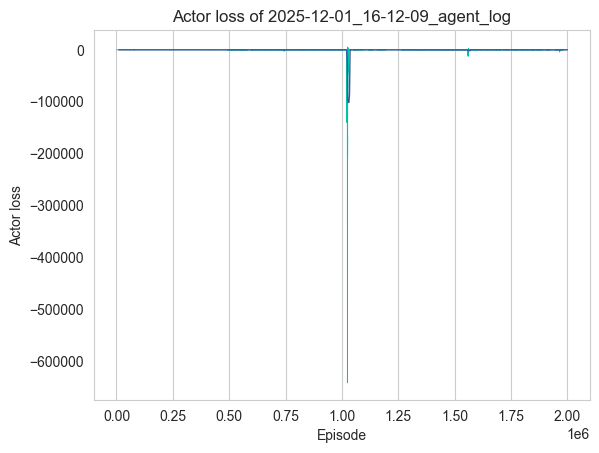

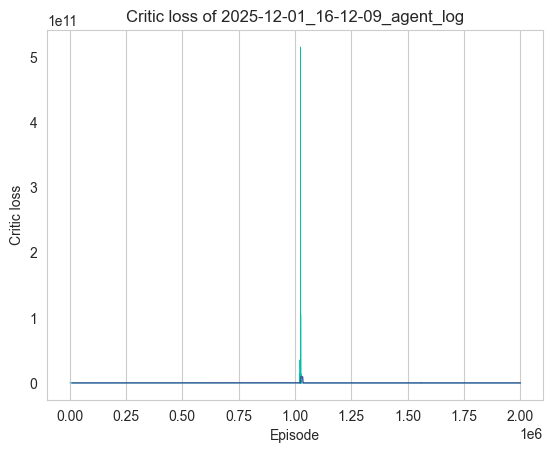

In [7]:
# Plot training properties of the agent (losses and entropy)
plot_log(type="agent", filename="2025-12-01_16-12-09_agent_log")

In [15]:
train_agent_df = load_log("2025-12-01_16-12-09_agent_log", type="agent")
train_agent_df.describe()

Actor loss       Critic loss  Entropy log coef  Entropy coef loss
count 2000000.0000      2000000.0000      2000000.0000       2000000.0000
mean     -529.7472     48017015.9247           -1.7367            -0.3264
std     13356.1786   2411887276.3219            0.7354             8.9107
min   -642231.1250            0.0000           -4.9319          -239.4609
25%       -18.9048           45.5525           -1.8518            -2.7533
50%       -12.2182           99.7767           -1.5595            -0.0107
75%        -2.5442          250.8347           -1.4482             2.6343
max      5593.3726 515765387264.0000            5.1977           132.9431

##### Testing

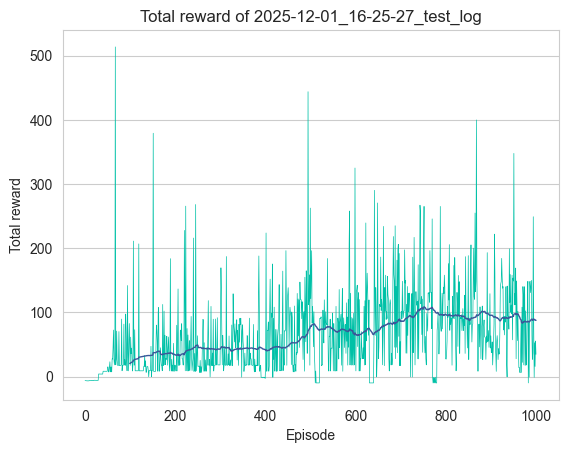

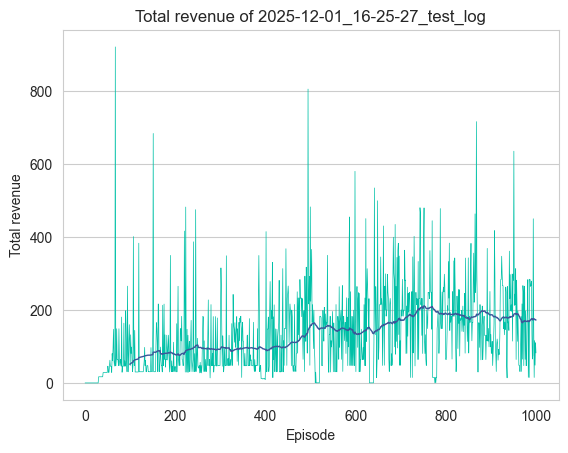

In [3]:
# Plot performance for deterministic periodic test episodes (10 test episodes per 20k training episodes)
plot_log(type="test", filename="2025-12-01_16-25-27_test_log")

In [10]:
test_episode_df = load_log("2025-12-01_16-25-27_test_log", type="test")
test_episode_df.describe()

Total reward  Reward/Step     Steps  Total revenue
count     1000.0000    1000.0000 1000.0000      1000.0000
mean        64.8340       5.2953    9.1170       132.4124
std         64.3038       3.6523    6.8257       114.2416
min        -10.0000     -10.0000    1.0000        -0.3928
25%         17.0834       4.2709    4.0000        46.7223
50%         46.2296       6.5572    7.0000       109.8687
75%         99.1895       7.7104   13.0000       197.5444
max        513.5073       9.1698   56.0000       920.3159

In [11]:
# Statistics for test phases (groups of 10 test episodes)
test_phase_df = test_episode_df.groupby(test_episode_df.index // 10).agg("mean")
test_phase_df.describe()

Total reward  Reward/Step    Steps  Total revenue
count      100.0000     100.0000 100.0000       100.0000
mean        64.8340       5.2953   9.1170       132.4124
std         40.2535       3.2540   4.2539        71.9976
min        -10.0000     -10.0000   1.0000        -0.3926
25%         35.4842       5.0088   5.9750        80.1109
50%         63.9413       6.0596   9.1000       132.8176
75%         94.2635       7.1237  12.2000       185.2615
max        179.9510       8.3849  21.1000       329.8249

In [ ]:
# Overview of best test phase
print("Test phases with max values:")
print(test_phase_df.idxmax())
best_test_phase = test_phase_df.idxmax().iloc[0]
print(f"Best test phase no. {best_test_phase+1} after {(best_test_phase+1)*20000} training episodes.")
print("\nMax values:")
print(test_phase_df.iloc[best_test_phase])
best_test_phase_df = test_episode_df.iloc[best_test_phase*10:(best_test_phase+1)*10]
best_test_phase_df

Test phases with max values:
Total reward     86
Reward/Step      86
Steps            86
Total revenue    86
dtype: int64
Best test phase no. 87 after 1740000 training episodes.

Max values:
Total reward    179.9510
Reward/Step       8.3849
Steps            21.1000
Total revenue   329.8249
Name: 86, dtype: float64


Total reward  Reward/Step   Steps  Total revenue
860      151.0484       8.3916 18.0000       279.0584
861      200.0048       8.6959 23.0000       355.2339
862      124.1105       8.2740 15.0000       220.5460
863      120.1985       8.0132 15.0000       230.5315
864      254.6971       8.7827 29.0000       462.8425
865      132.0339       8.2521 16.0000       247.3357
866      148.5501       8.2528 18.0000       281.0415
867      399.7577       9.0854 44.0000       715.6591
868      170.8443       8.5422 20.0000       309.0330
869       98.2644       7.5588 13.0000       196.9678

In [ ]:
# Statistics for best test phase
best_test_phase_df.describe()

Total reward  Reward/Step   Steps  Total revenue
count       10.0000      10.0000 10.0000        10.0000
mean       179.9510       8.3849 21.1000       329.8249
std         89.3593       0.4267  9.2910       155.9392
min         98.2644       7.5588 13.0000       196.9678
25%        126.0914       8.2523 15.2500       234.7326
50%        149.7992       8.3328 18.0000       280.0499
75%        192.7147       8.6575 22.2500       343.6837
max        399.7577       9.0854 44.0000       715.6591

Creating 31 plots for 1 cycle with each 1 episodes with 31 variables...


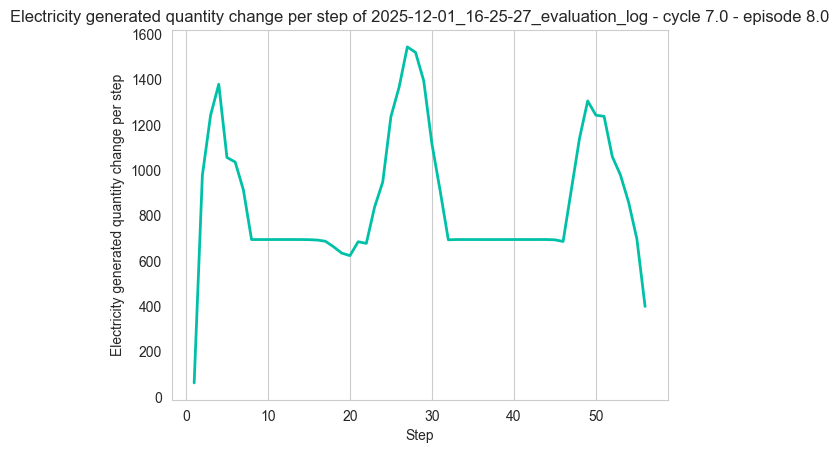

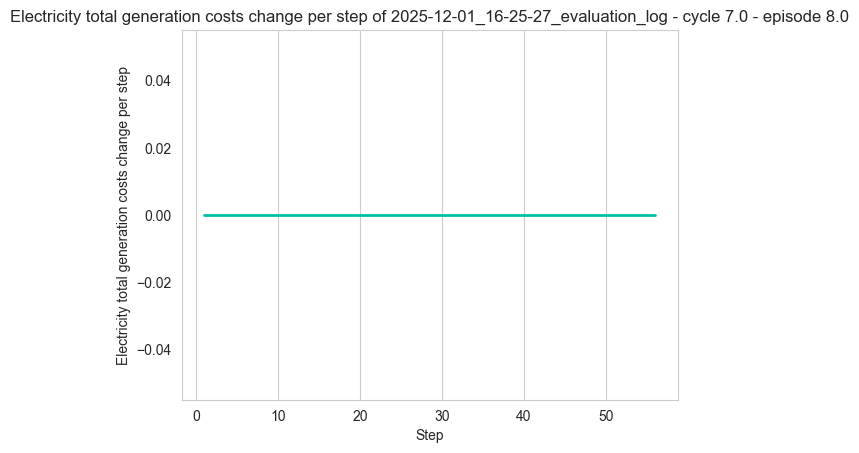

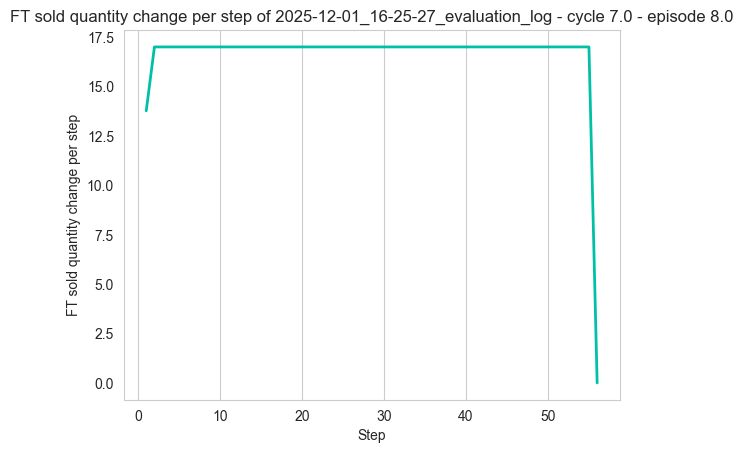

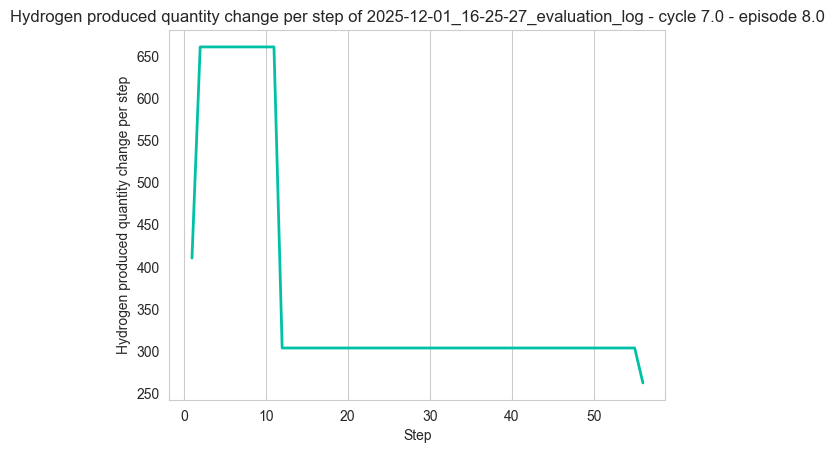

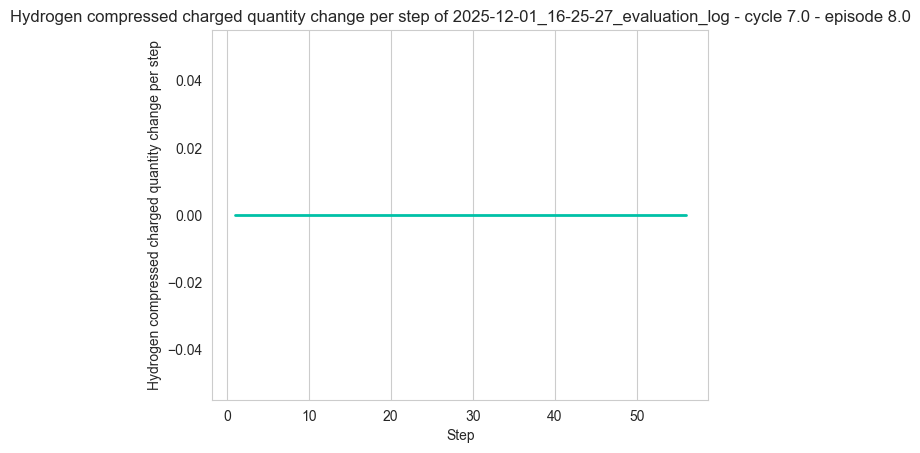

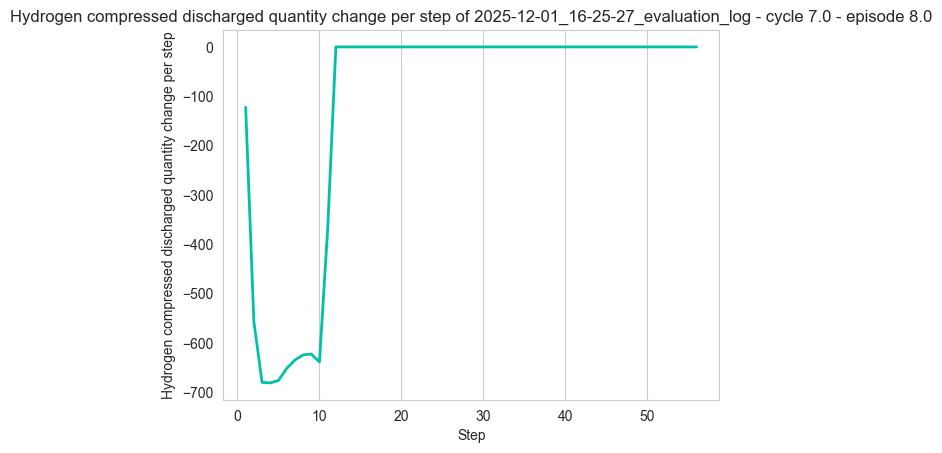

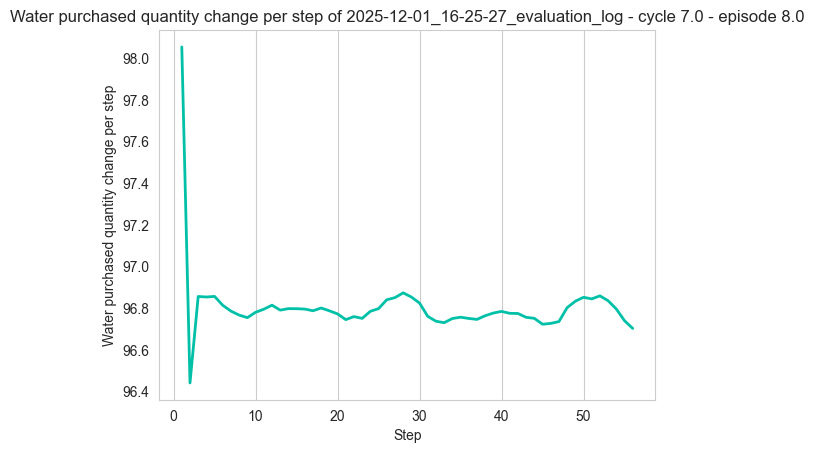

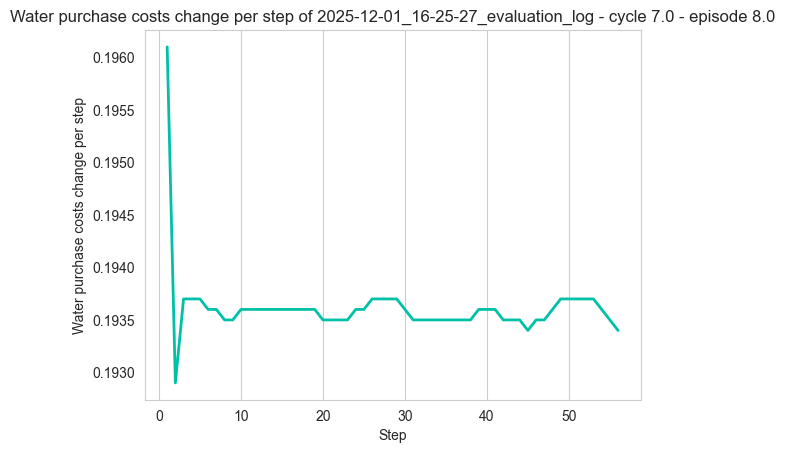

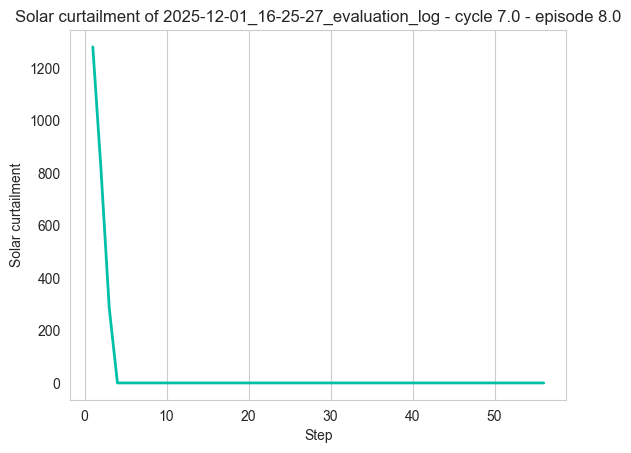

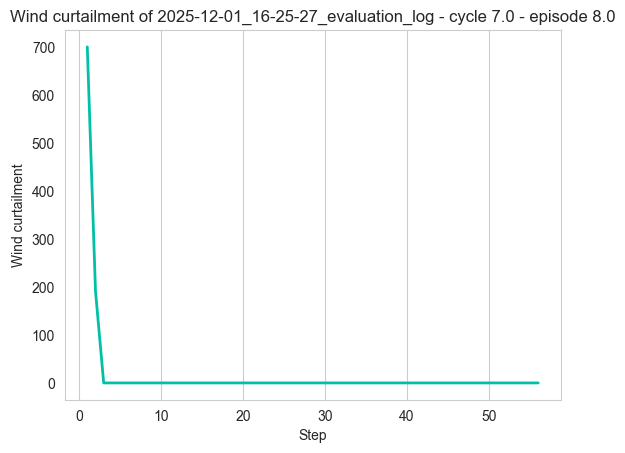

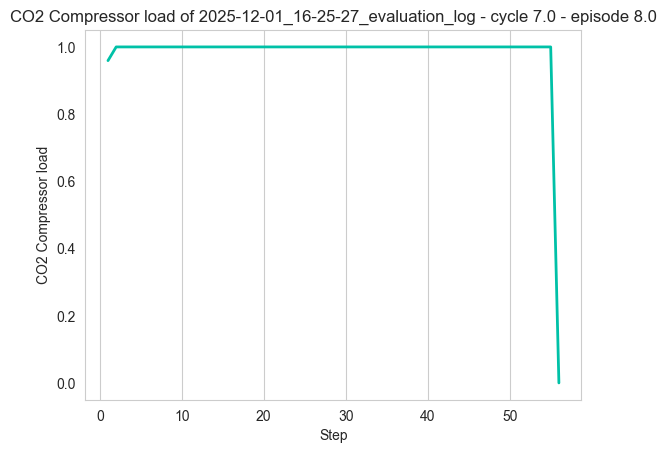

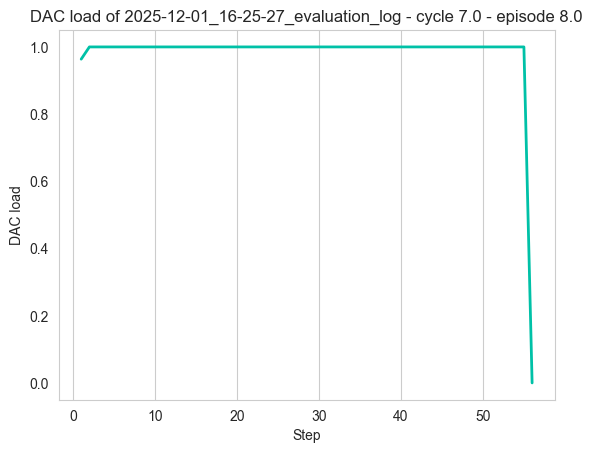

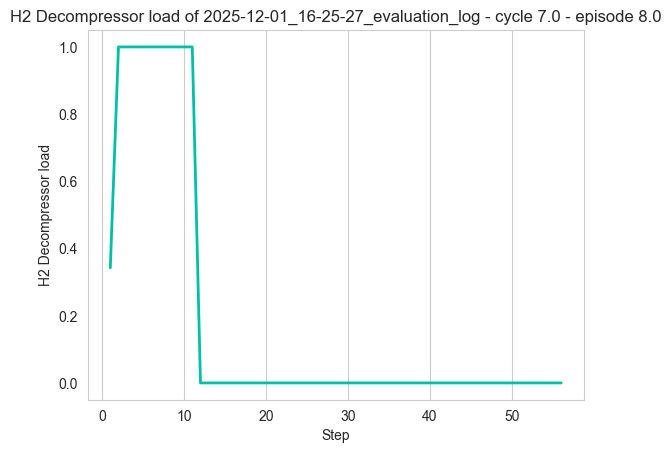

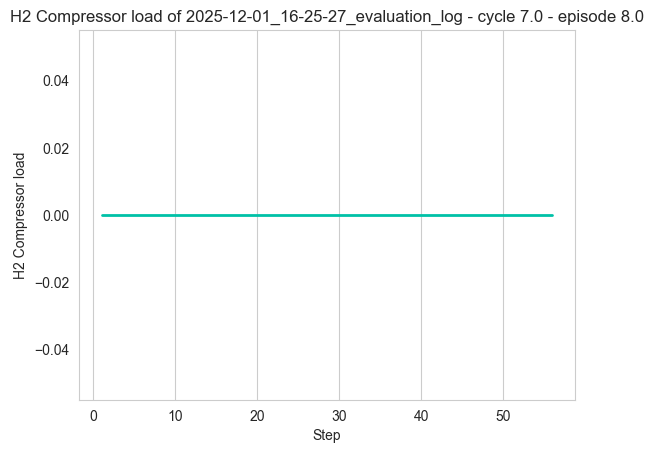

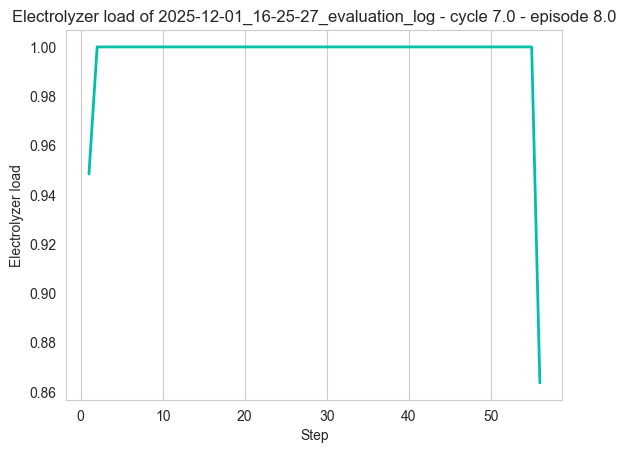

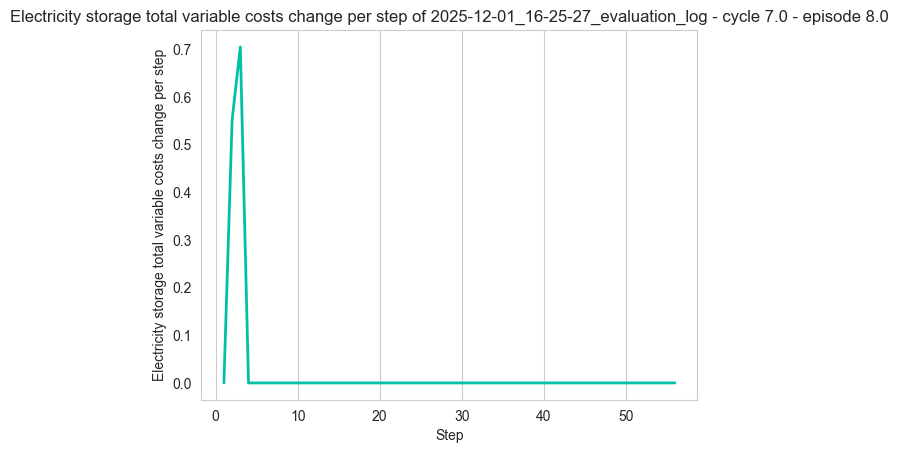

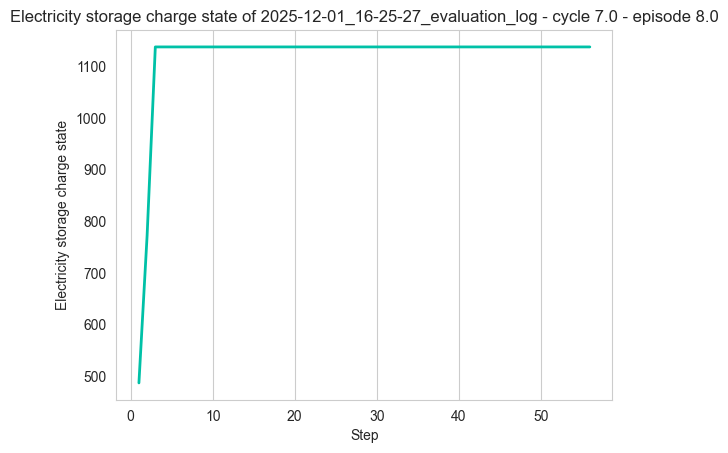

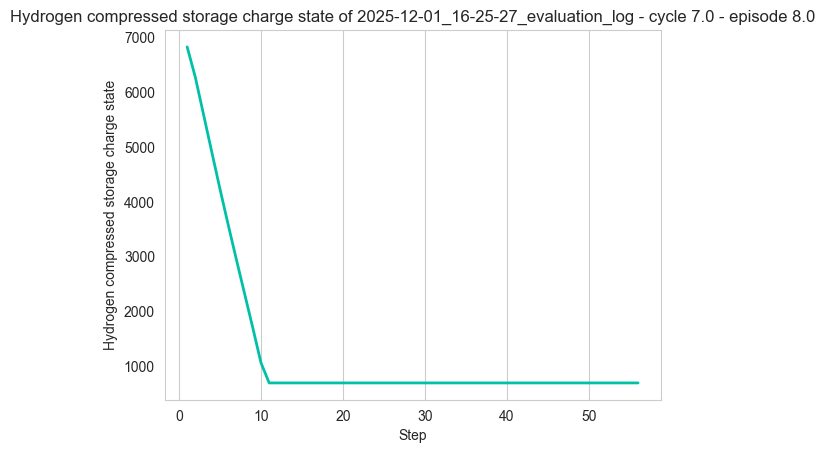

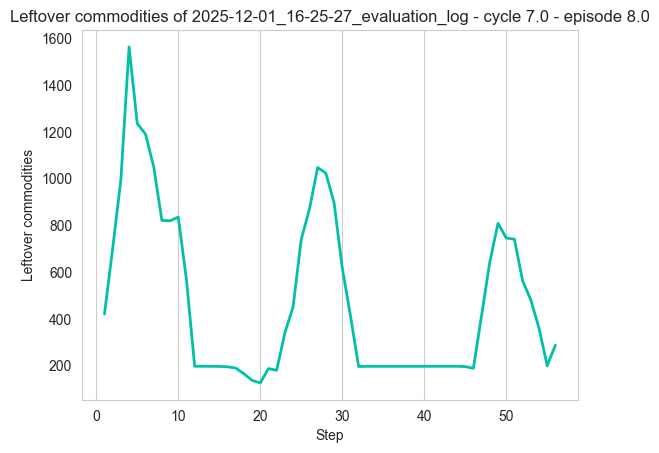

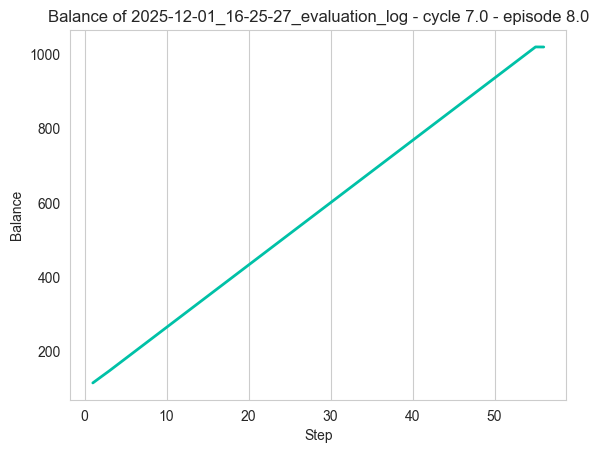

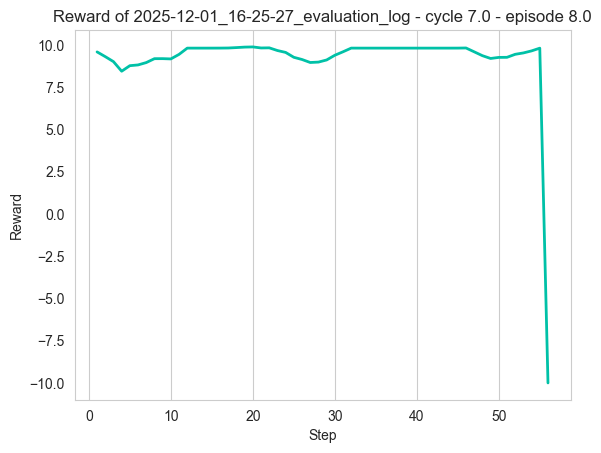

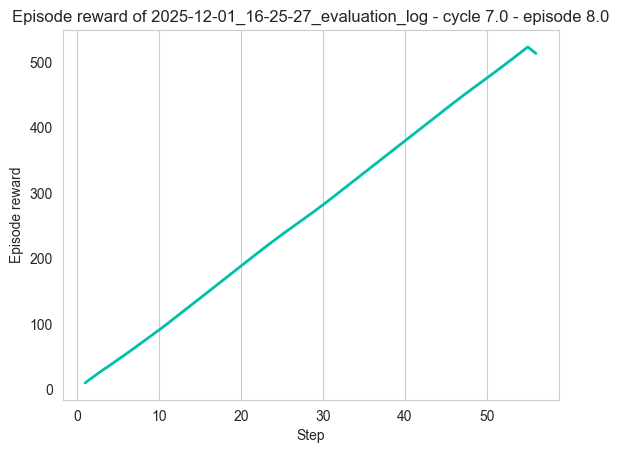

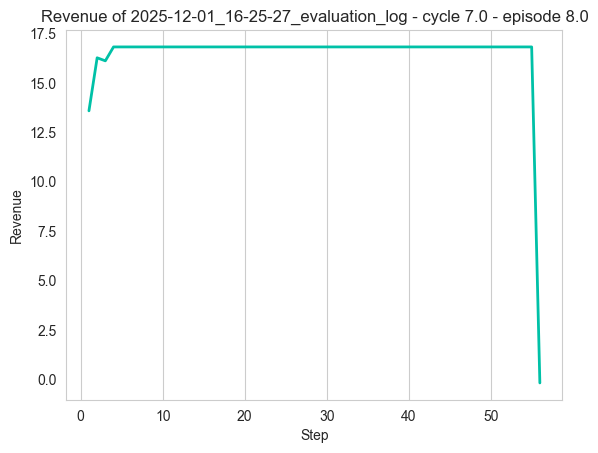

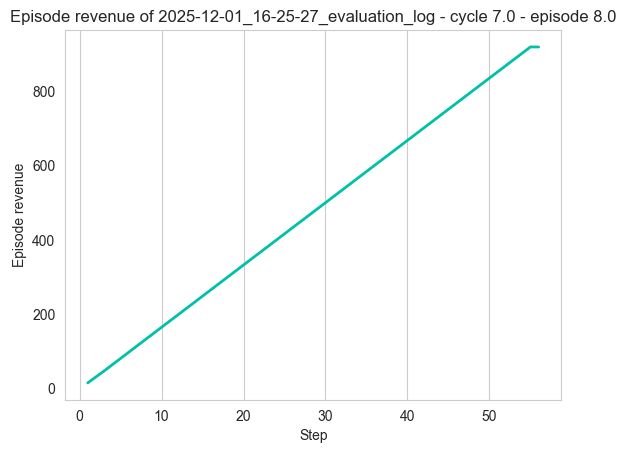

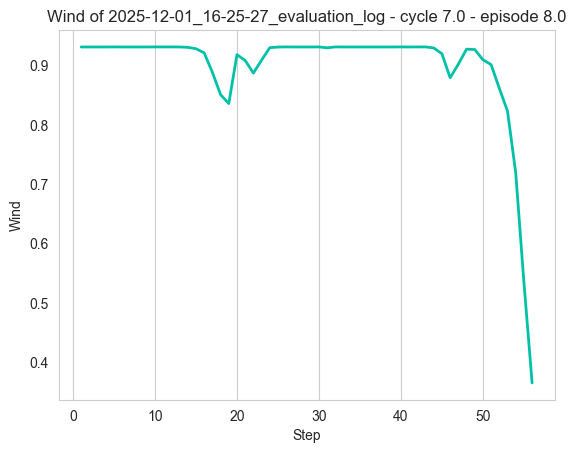

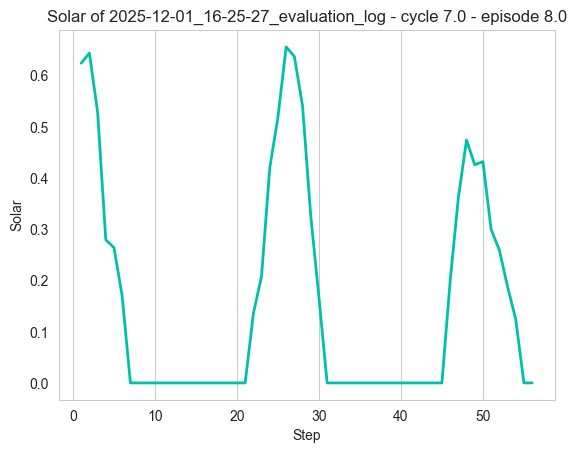

In [ ]:
# Plot detailed statistics for overall best episode
plot_log(type="evaluation", cycle=[7], episode=[8], filename="2025-12-01_16-25-27_evaluation_log")

Creating 31 plots for 1 cycle with each 1 episodes with 31 variables...


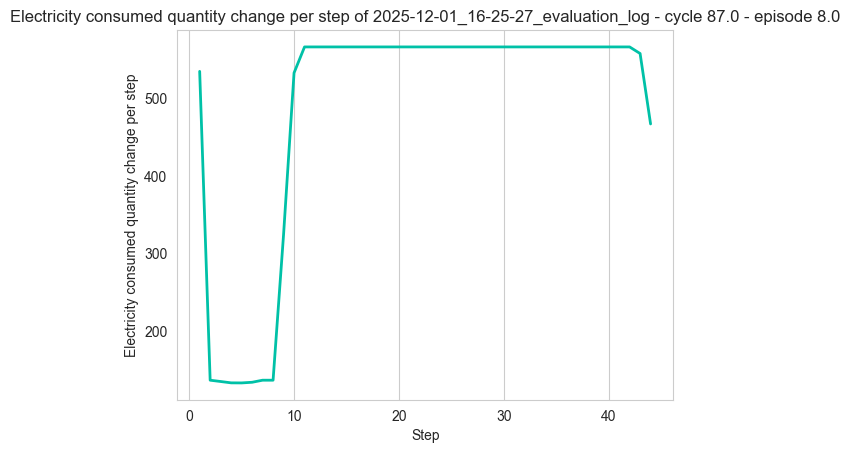

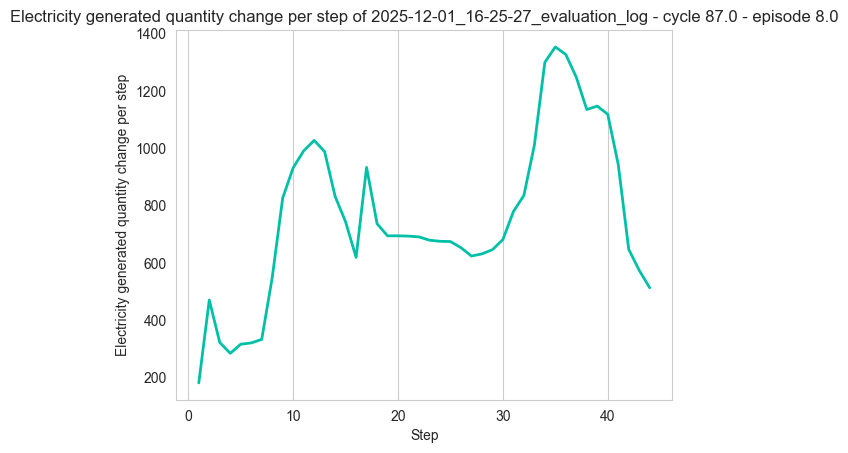

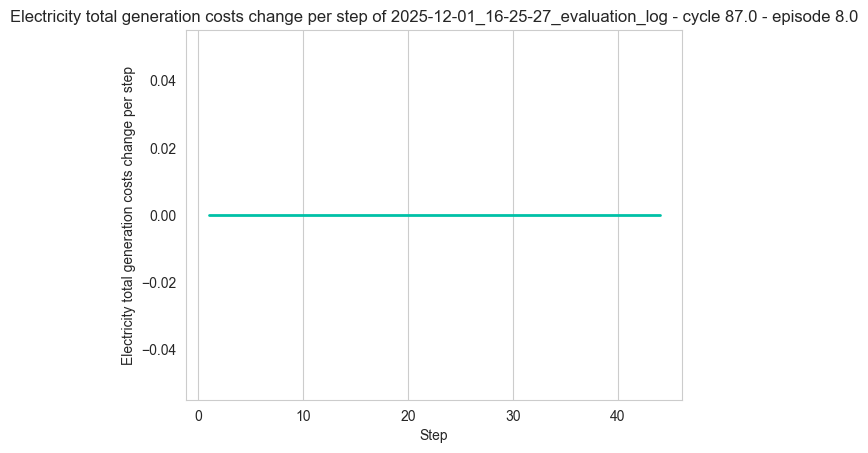

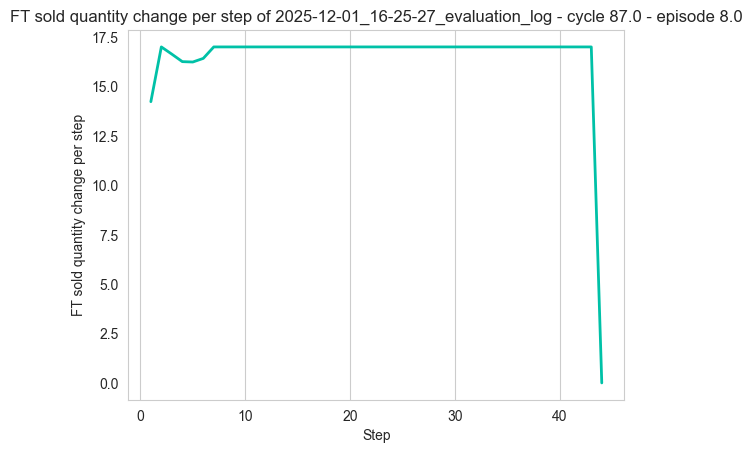

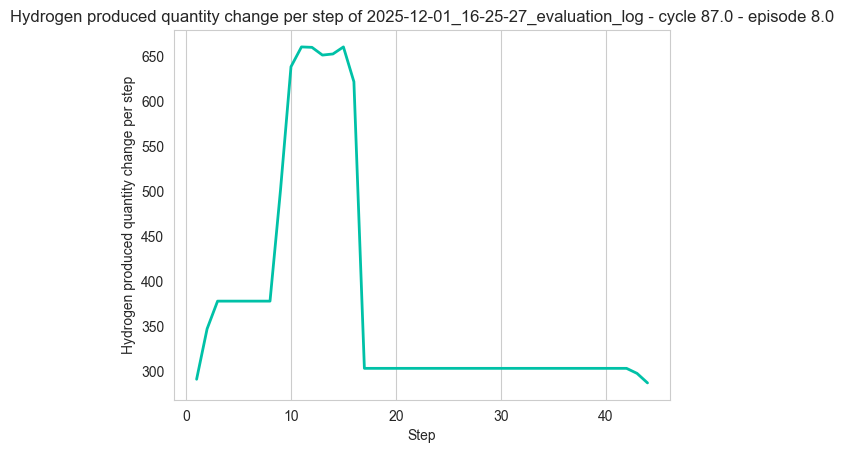

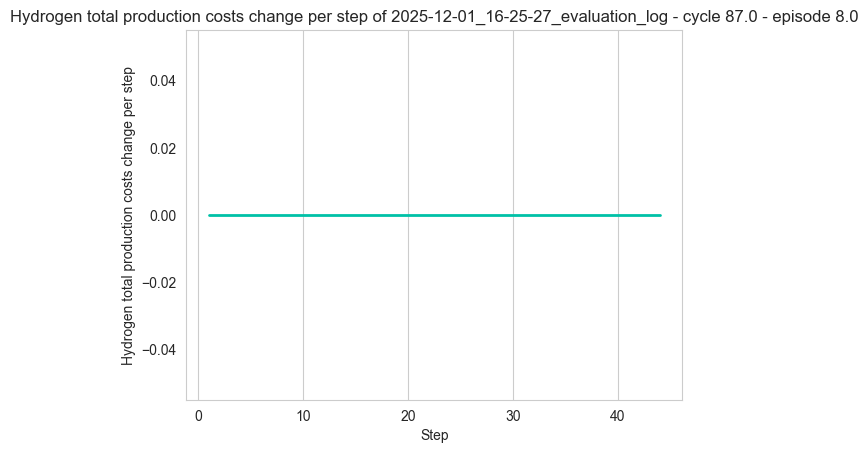

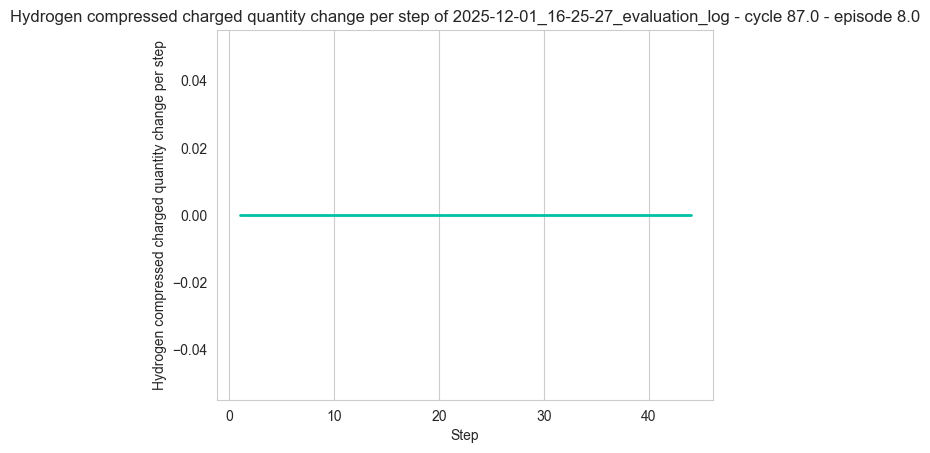

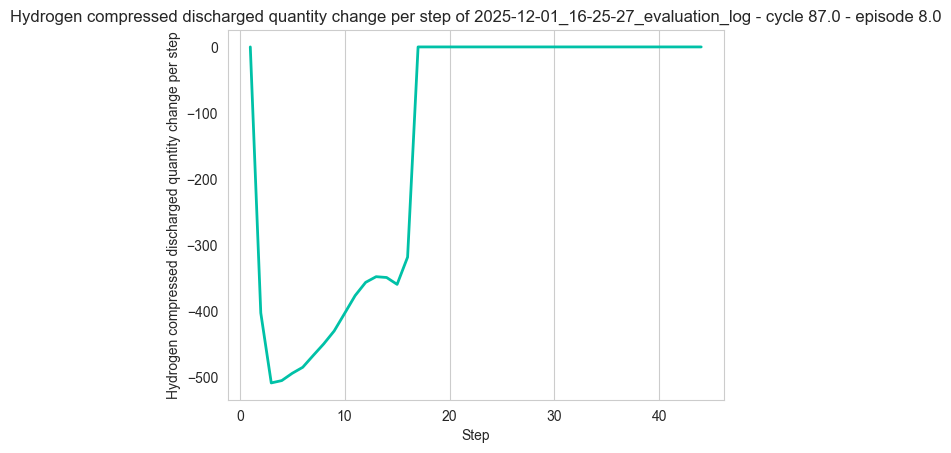

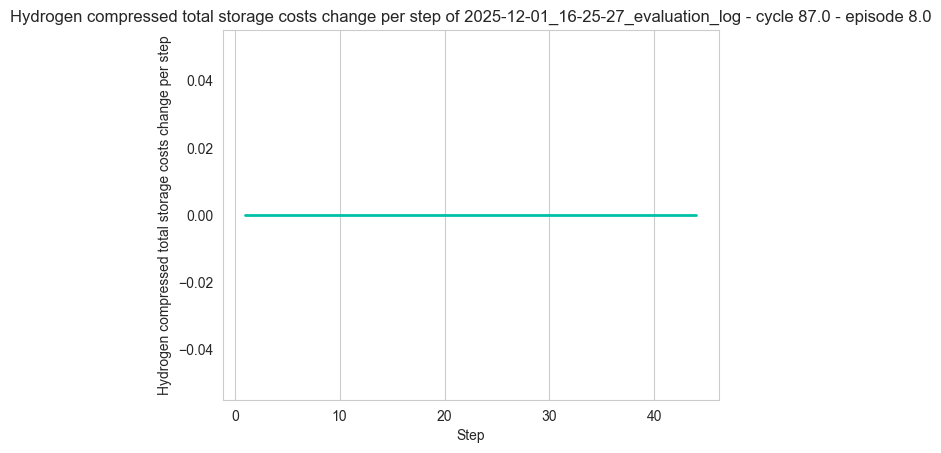

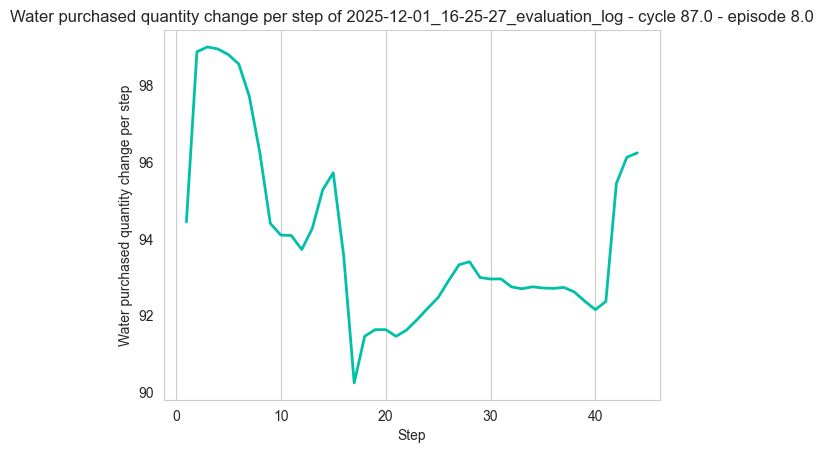

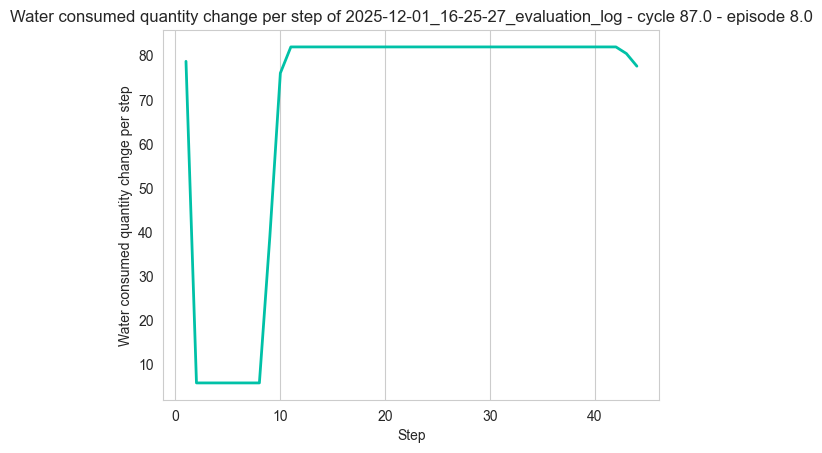

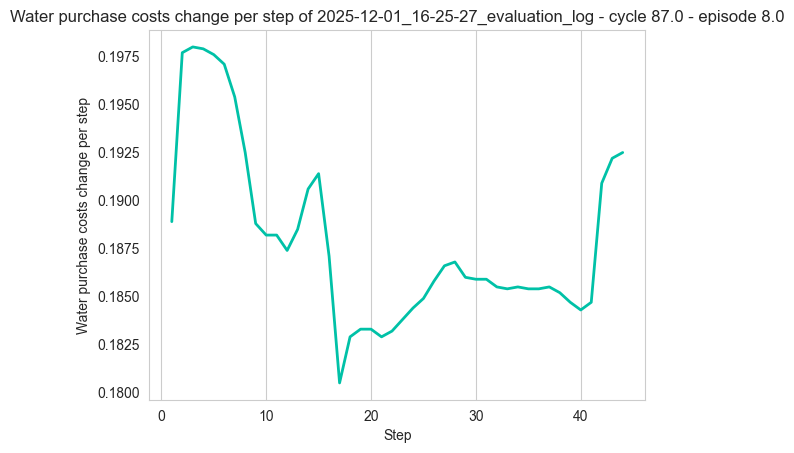

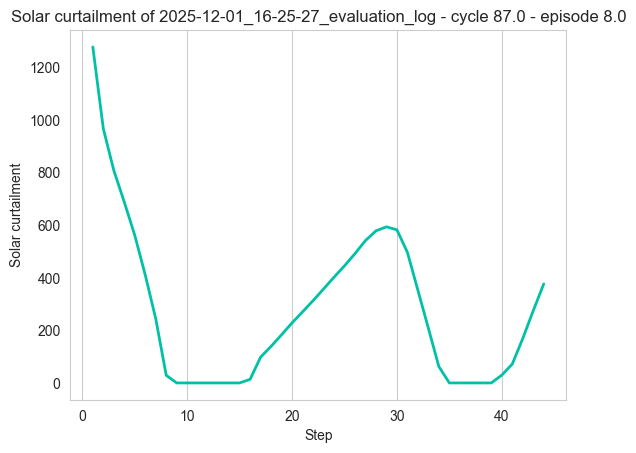

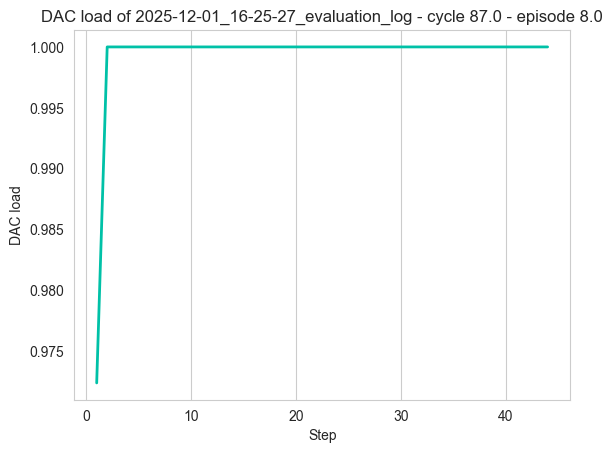

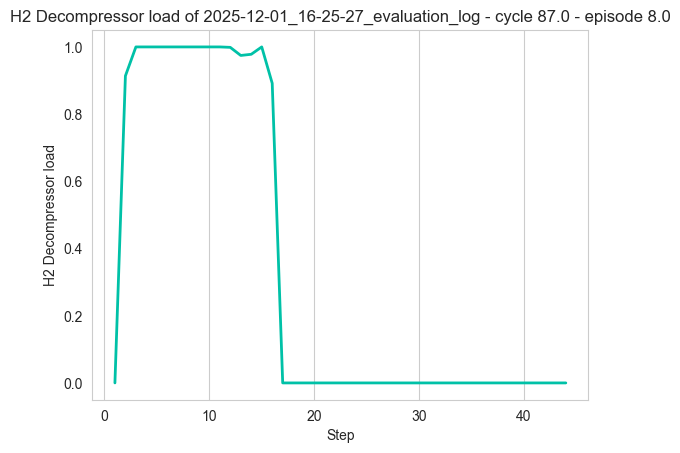

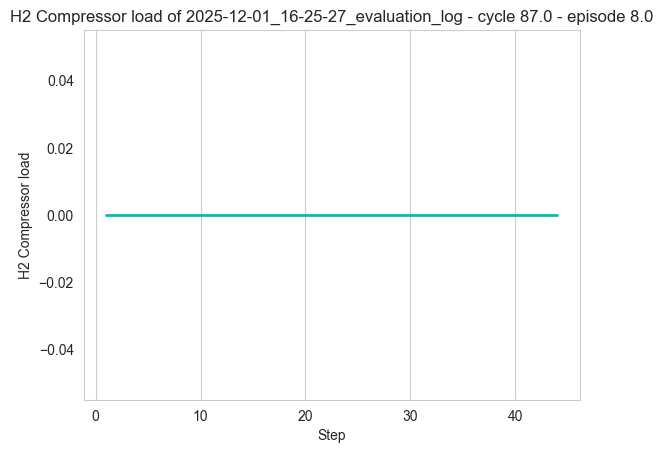

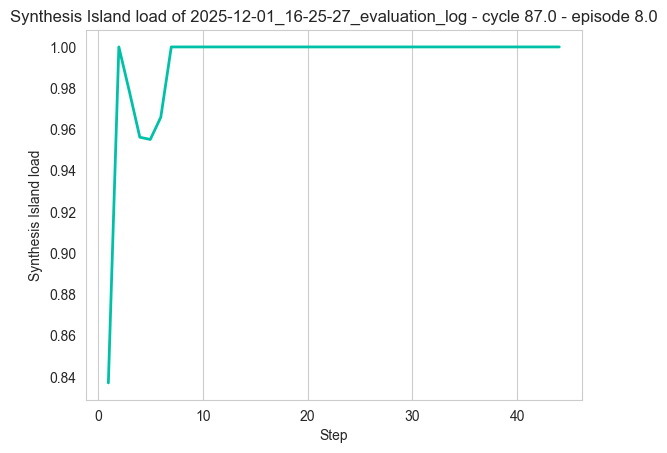

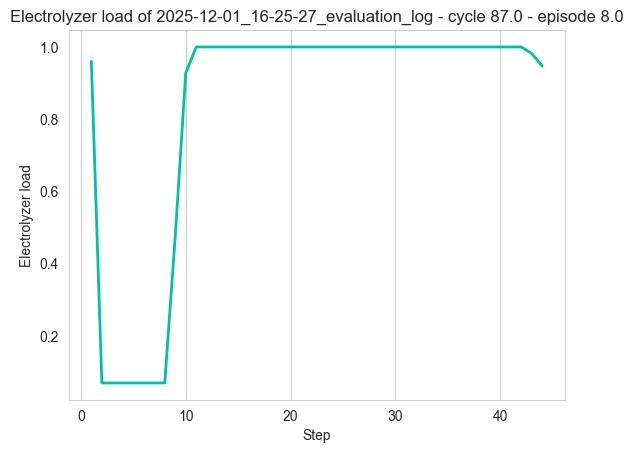

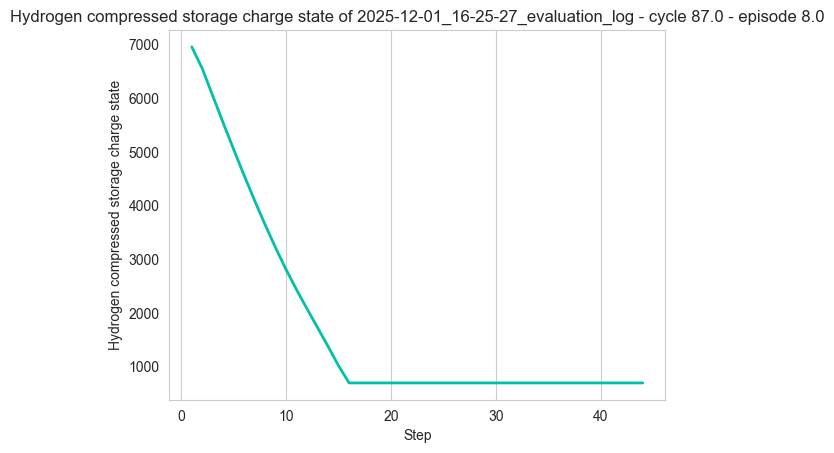

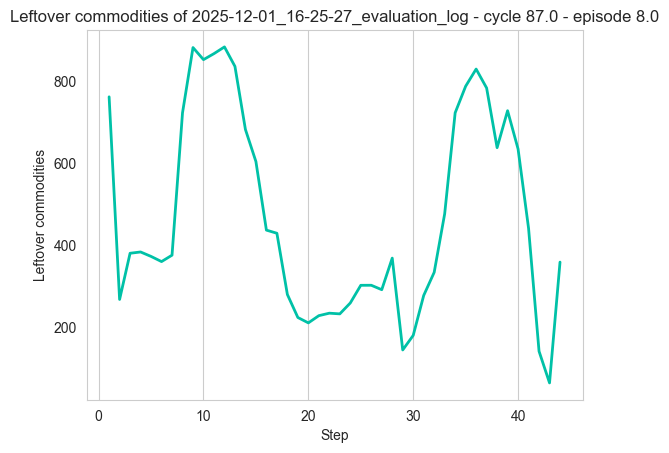

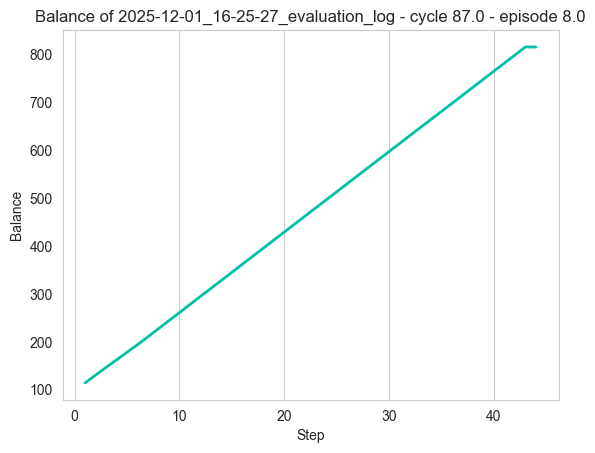

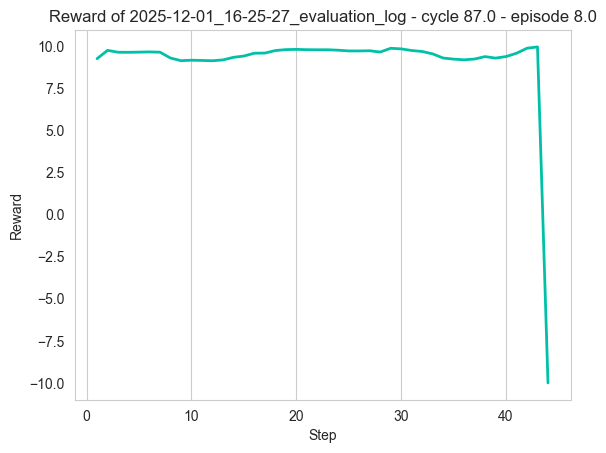

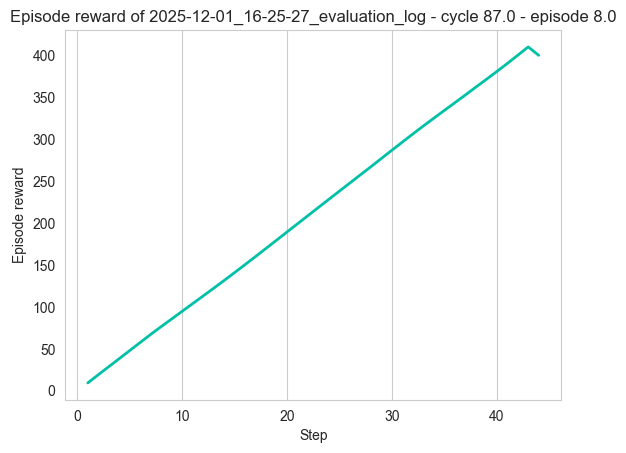

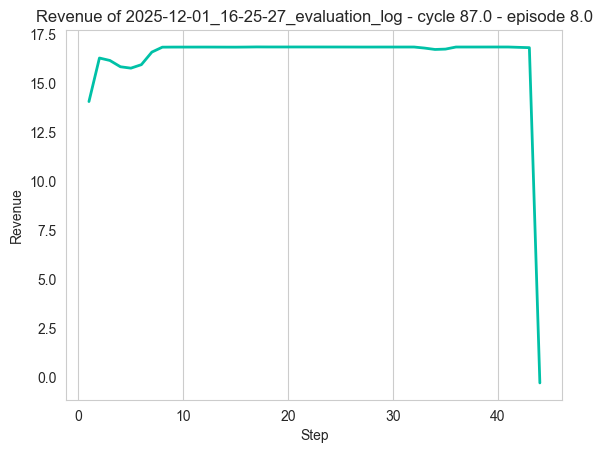

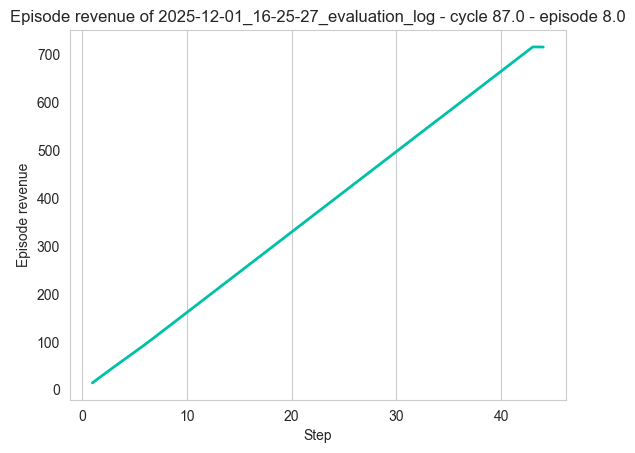

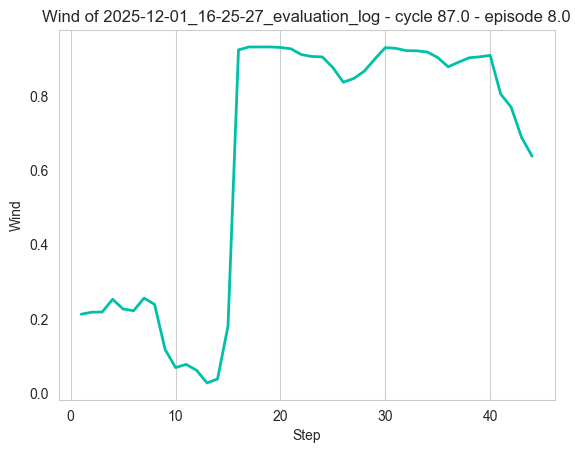

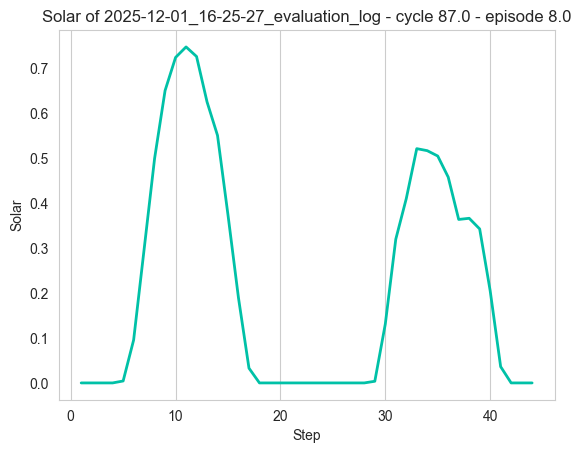

In [ ]:
# Plot detailed statistics for best episode of best test phase
plot_log(type="evaluation", cycle=[87], episode=[8], filename="2025-12-01_16-25-27_evaluation_log")

#### Using reward function with fixed +10 reward for success to maximize steps

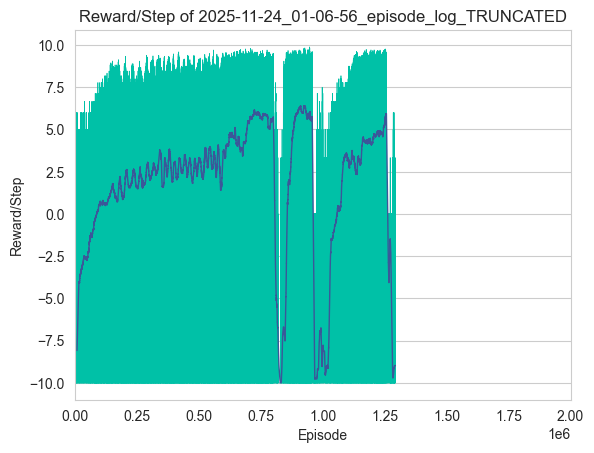

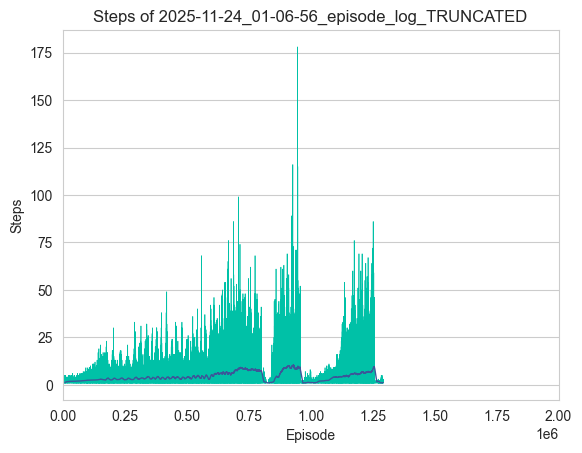

In [ ]:
# Plot training performance in PtX environment (reward, revenue, and steps per episode)
plot_log(filename="2025-11-24_01-06-56_episode_log_TRUNCATED")

In [5]:
train_episode_df2 = load_log("2025-11-24_01-06-56_episode_log_TRUNCATED")
train_episode_df2.describe()

Total reward  Reward/Step        Steps  Total revenue
count  1293000.0000 1293000.0000 1293000.0000   1293000.0000
mean        22.6682       1.6040       4.2668        16.5394
std         41.7607       5.8178       4.1761        30.7592
min        -10.0000     -10.0000       1.0000       -18.5701
25%          0.0000       0.0000       2.0000        -0.3907
50%         10.0000       3.3333       3.0000         6.3486
75%         30.0000       6.0000       5.0000        16.1915
max       1760.0000       9.8876     178.0000      1112.2934

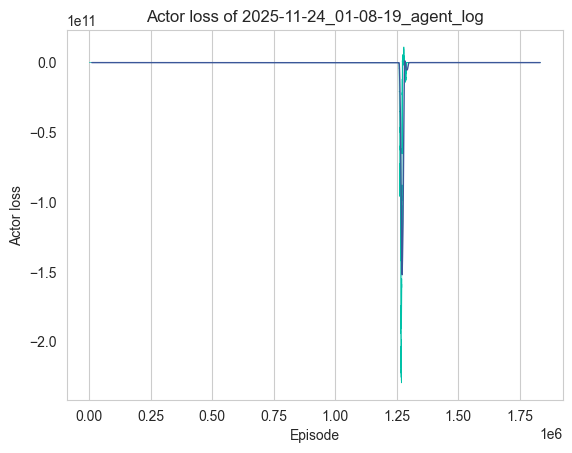

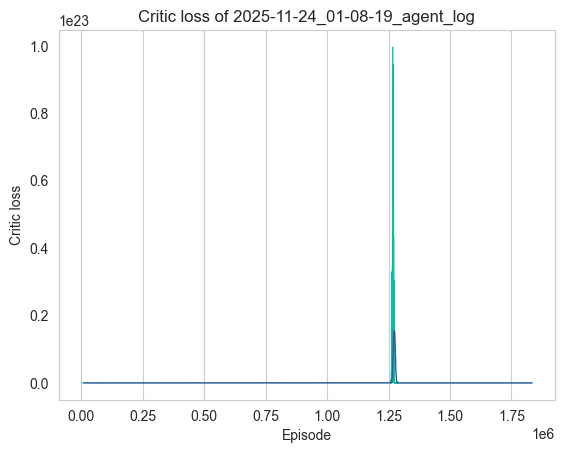

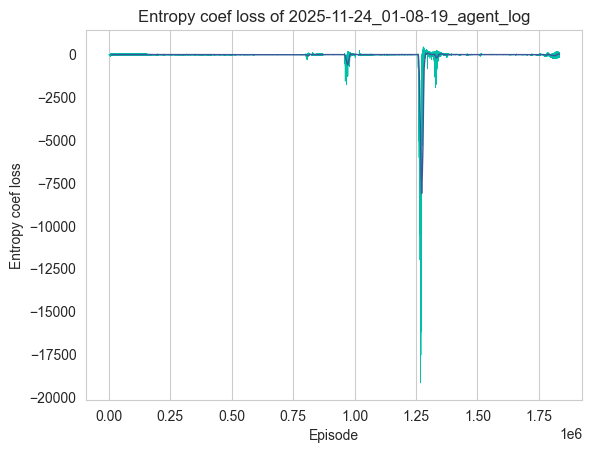

In [7]:
# Plot training properties of the agent (losses and entropy)
plot_log(type="agent", filename="2025-11-24_01-08-19_agent_log")

In [9]:
train_agent_df2 = load_log("2025-11-24_01-08-19_agent_log", type="agent")
train_agent_df2.describe()

Actor loss                  Critic loss  Entropy log coef  \
count       1833995.0000                 1833995.0000      1833995.0000   
mean     -906268512.4423    89780859183014821888.0000           -0.9813   
std     12071558241.3801  1536781792936816803840.0000            4.0130   
min   -229562859520.0000                       0.0000          -19.8992   
25%             -14.8296                      81.2037           -2.0196   
50%              -3.4636                     242.6836           -1.4929   
75%               9.9463                   31787.2573           -0.9580   
max     11240518656.0000 99645708606477101432832.0000           18.2377   

       Entropy coef loss  
count       1833995.0000  
mean            -58.6086  
std             651.7033  
min          -19179.2168  
25%              -3.2413  
50%              -0.0318  
75%               2.9430  
max             448.1767

##### Testing

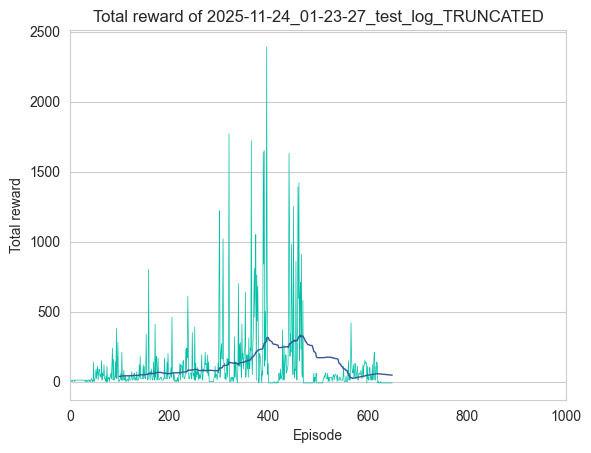

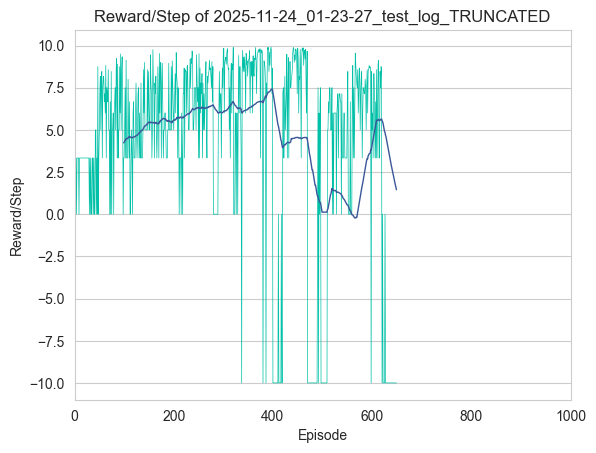

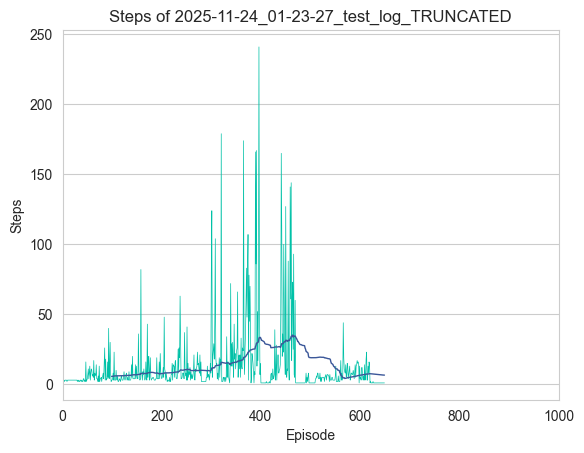

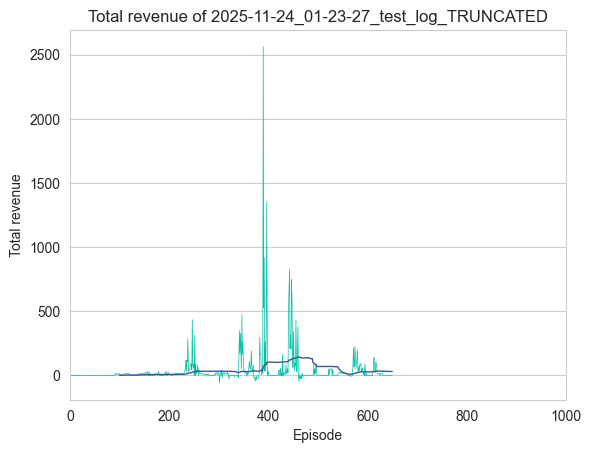

In [5]:
# Plot performance for deterministic periodic test episodes (10 test episodes per 20k training episodes)
plot_log(type="test", filename="2025-11-24_01-23-27_test_log_TRUNCATED")

In [15]:
test_episode_df2 = load_log("2025-11-24_01-23-27_test_log_TRUNCATED", type="test")
test_episode_df2.describe()

Total reward  Reward/Step    Steps  Total revenue
count      650.0000     650.0000 650.0000       650.0000
mean       109.3692       3.9686  12.9369        37.2472
std        249.9937       6.0314  24.9994       145.6028
min        -10.0000     -10.0000   1.0000       -59.7228
25%         10.0000       3.3333   3.0000        -0.7669
50%         30.0000       6.0000   5.0000         2.2858
75%        110.0000       8.4615  13.0000        16.4384
max       2390.0000       9.9170 241.0000      2559.8017

In [16]:
# Statistics for test phases (groups of 10 test episodes)
test_phase_df2 = test_episode_df2.groupby(test_episode_df2.index // 10).agg("mean")
test_phase_df2.describe()

Total reward  Reward/Step   Steps  Total revenue
count       65.0000      65.0000 65.0000        65.0000
mean       109.3692       3.9686 12.9369        37.2472
std        158.9076       5.5443 15.8908        87.9366
min        -10.0000     -10.0000  1.0000       -23.8003
25%         16.0000       3.3333  3.6000        -0.8639
50%         57.0000       6.2121  7.7000         6.0128
75%        109.0000       7.0126 12.9000        18.5373
max        709.0000       9.2665 72.9000       426.6197

In [ ]:
# Overview of best test phases: actually 2 competing phases with different best scores
print("Test phases with max values:")
print(test_phase_df2.idxmax())
best_test_phase2_1 = test_phase_df2.idxmax().iloc[0]
best_test_phase2_2 = test_phase_df2.idxmax().iloc[1]

# First best test phase with best "Total reward" and "Steps"
print(f"Best test phase 1 no. {best_test_phase2_1+1} after {(best_test_phase2_1+1)*20000} training episodes.")
print("\nMax values:")
print(test_phase_df2.iloc[best_test_phase2_1])
best_test_phase2_1_df = test_episode_df2.iloc[best_test_phase2_1*10:(best_test_phase2_1+1)*10]
best_test_phase2_1_df

Test phases with max values:
Total reward     39
Reward/Step      44
Steps            39
Total revenue    44
dtype: int64
Best test phase 1 no. 40 after 800000 training episodes.

Max values:
Total reward    709.0000
Reward/Step       9.1662
Steps            72.9000
Total revenue   388.3886
Name: 39, dtype: float64


Total reward  Reward/Step    Steps  Total revenue
390      840.0000       9.7674  86.0000       527.8409
391     1650.0000       9.8802 167.0000       917.2751
392      110.0000       8.4615  13.0000        32.0823
393      500.0000       9.6154  52.0000       266.4533
394      150.0000       8.8235  17.0000        32.5695
395      600.0000       9.6774  62.0000       315.4646
396     2390.0000       9.9170 241.0000      1351.4742
397      670.0000       9.7101  69.0000       405.9174
398       50.0000       7.1429   7.0000        -0.6126
399      130.0000       8.6667  15.0000        35.4213

In [ ]:
# Statistics for first best test phase
best_test_phase2_1_df.describe()

Total reward  Reward/Step    Steps  Total revenue
count       10.0000      10.0000  10.0000        10.0000
mean       709.0000       9.1662  72.9000       388.3886
std        762.0360       0.8914  76.2036       444.3052
min         50.0000       7.1429   7.0000        -0.6126
25%        135.0000       8.7059  15.5000        33.2824
50%        550.0000       9.6464  57.0000       290.9590
75%        797.5000       9.7531  81.7500       497.3600
max       2390.0000       9.9170 241.0000      1351.4742

In [24]:
# Second best test phase with best "Reward/Step" and "Total revenue"
print(f"Best test phase 2 no. {best_test_phase2_2+1} after {(best_test_phase2_2+1)*20000} training episodes.")
print("\nMax values:")
print(test_phase_df2.iloc[best_test_phase2_2])
best_test_phase2_2_df = test_episode_df2.iloc[best_test_phase2_2*10:(best_test_phase2_2+1)*10]
best_test_phase2_2_df

Best test phase 2 no. 45 after 900000 training episodes.

Max values:
Total reward    579.0000
Reward/Step       9.2665
Steps            59.9000
Total revenue   426.6197
Name: 44, dtype: float64


Total reward  Reward/Step    Steps  Total revenue
440      480.0000       9.6000  50.0000       499.0918
441     1630.0000       9.8788 165.0000       667.2785
442     1090.0000       9.8198 111.0000       827.6288
443      180.0000       9.0000  20.0000       210.4308
444      340.0000       9.4444  36.0000       315.5240
445      210.0000       9.1304  23.0000       205.0513
446      980.0000       9.8000 100.0000       746.7337
447      610.0000       9.6825  63.0000       582.4094
448      220.0000       9.1667  24.0000       152.3101
449       50.0000       7.1429   7.0000        59.7386

In [ ]:
# Statistics for second best test phase
best_test_phase2_2_df.describe()

Total reward  Reward/Step    Steps  Total revenue
count       10.0000      10.0000  10.0000        10.0000
mean       579.0000       9.2665  59.9000       426.6197
std        505.3591       0.8090  50.5359       272.5885
min         50.0000       7.1429   7.0000        59.7386
25%        212.5000       9.1395  23.2500       206.3962
50%        410.0000       9.5222  43.0000       407.3079
75%        887.5000       9.7706  90.7500       646.0612
max       1630.0000       9.8788 165.0000       827.6288

Creating 31 plots for 1 cycle with each 1 episodes with 31 variables...


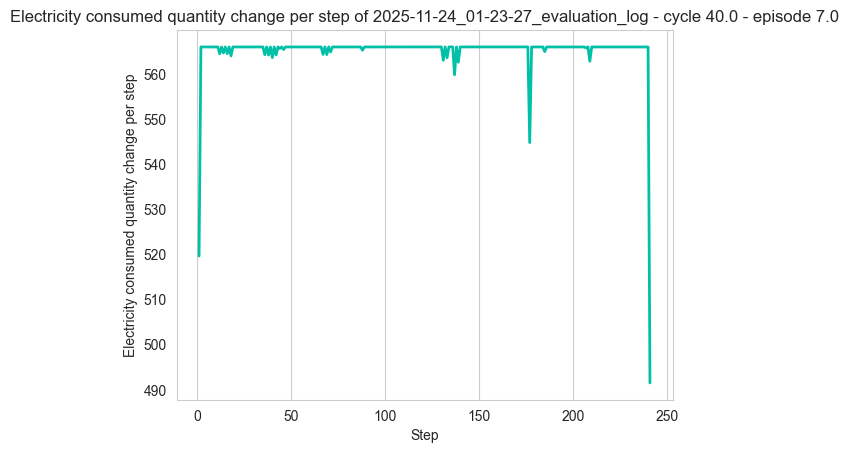

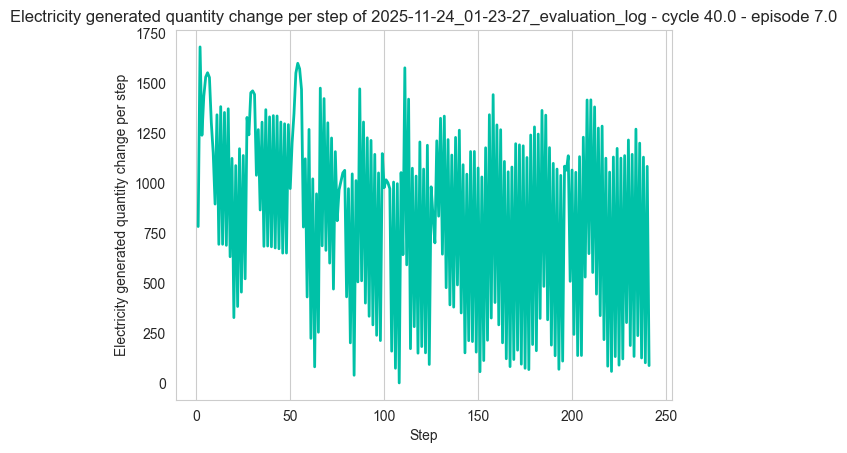

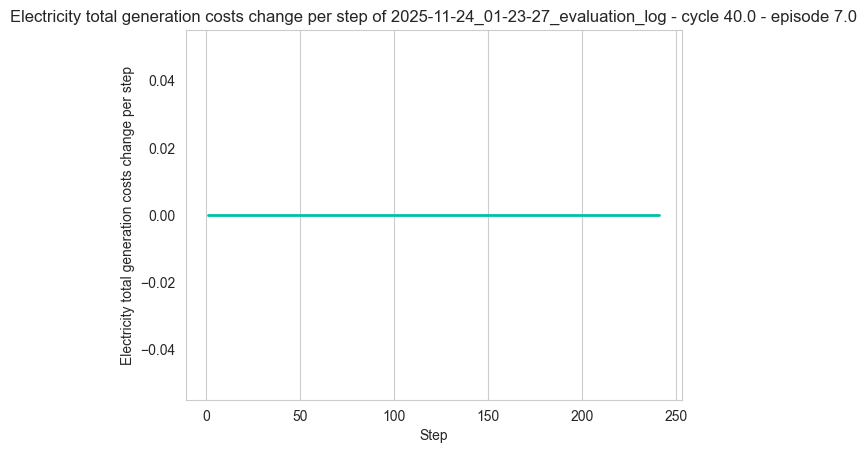

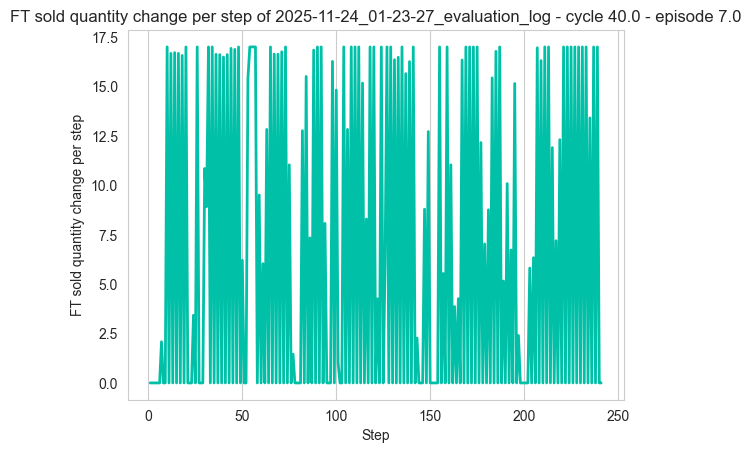

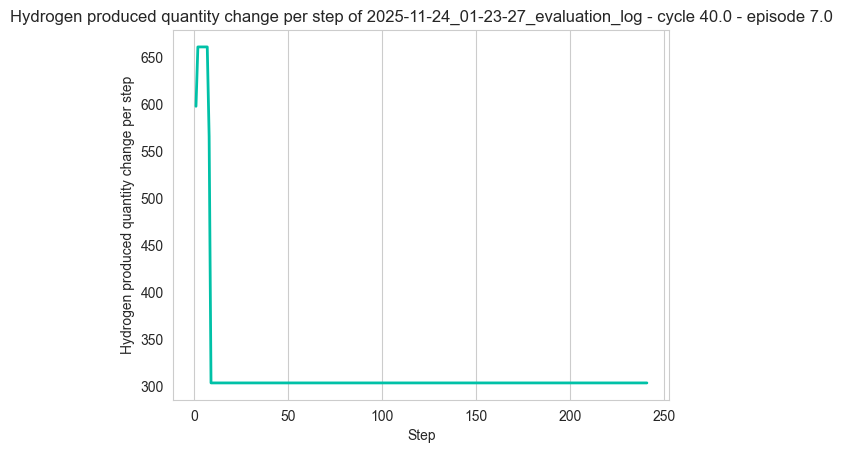

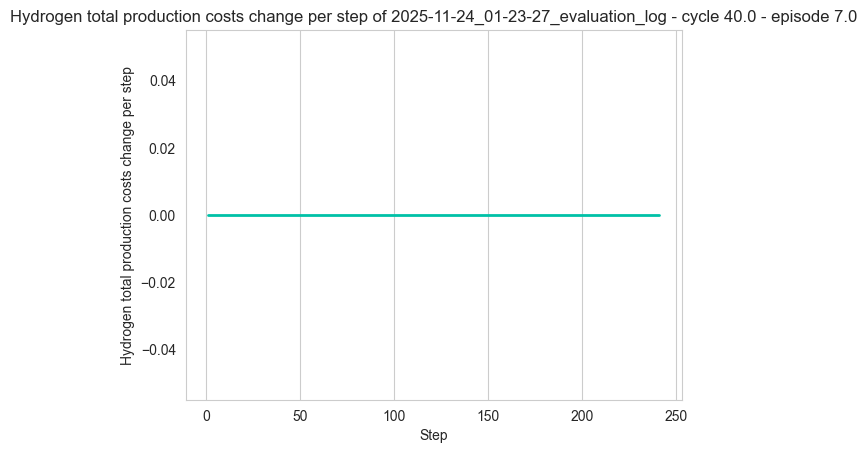

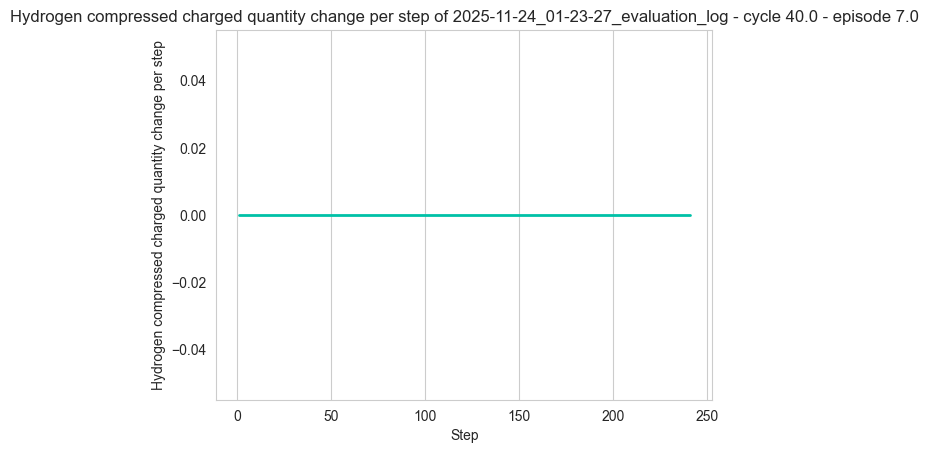

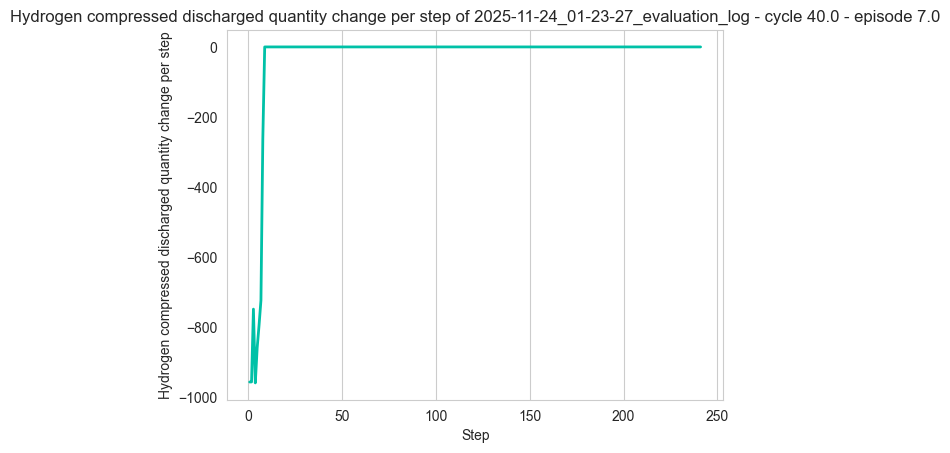

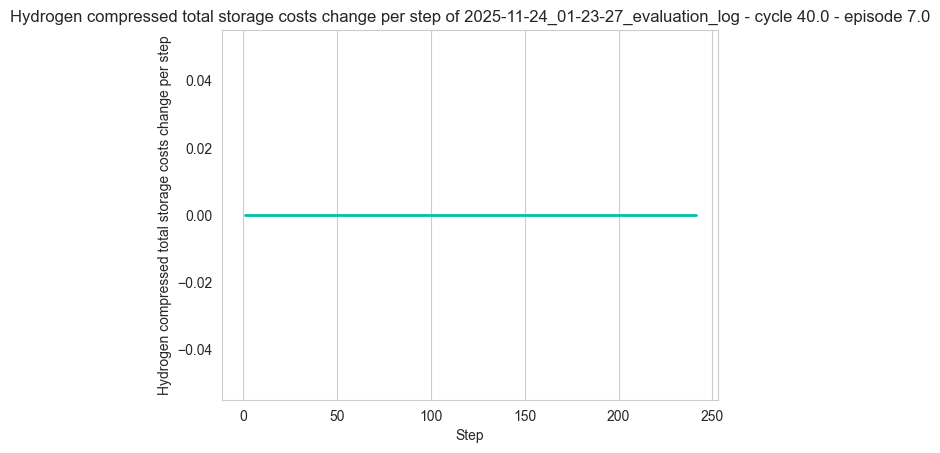

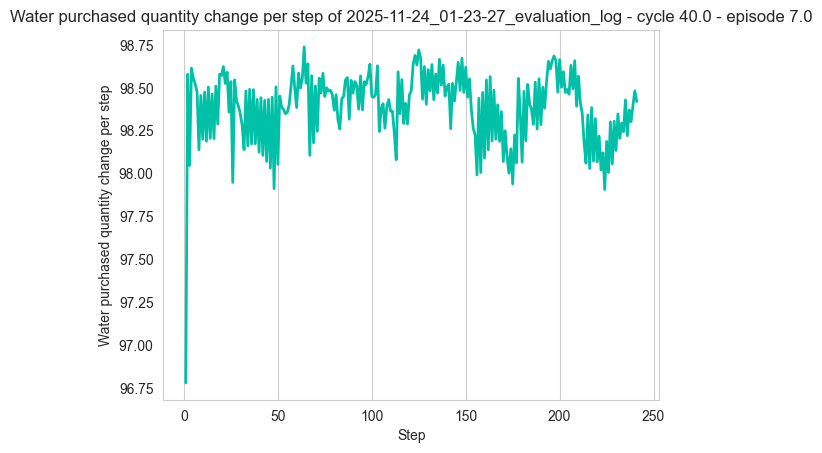

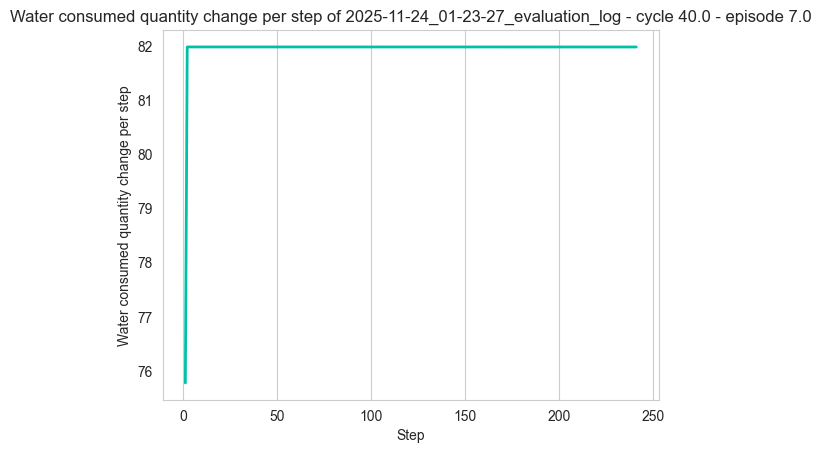

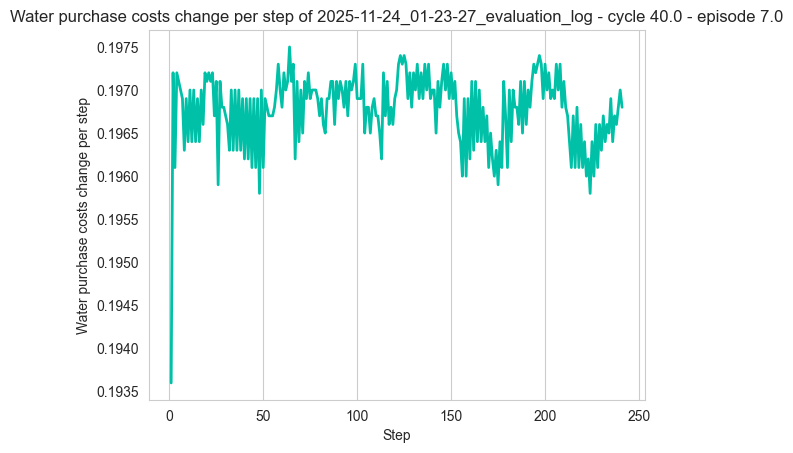

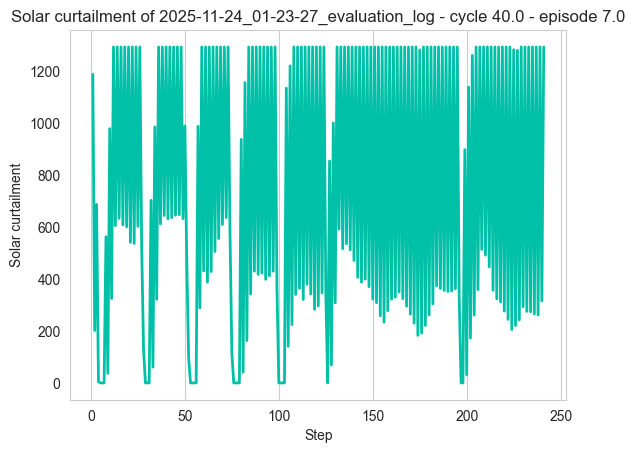

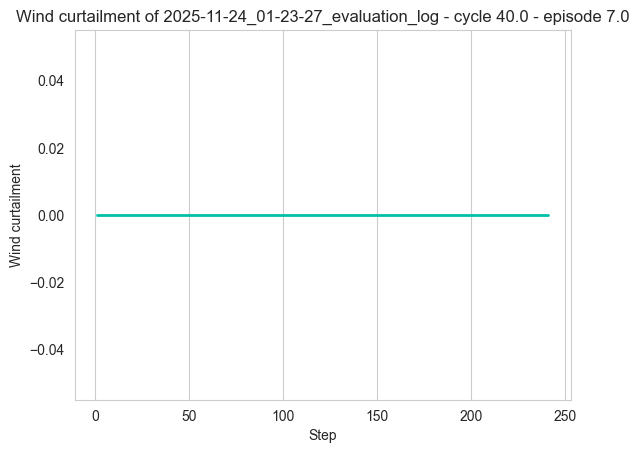

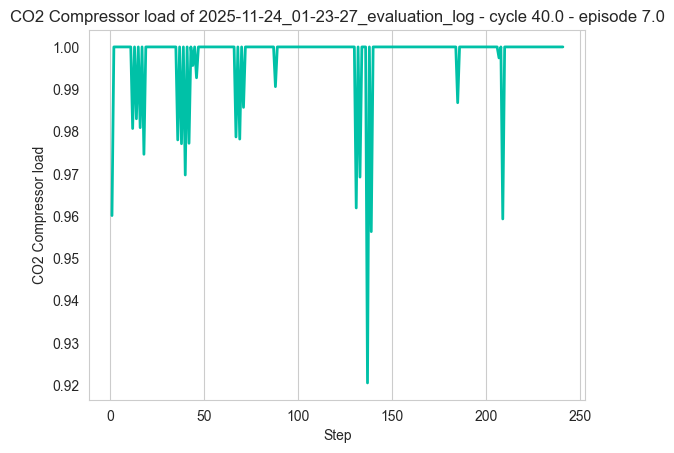

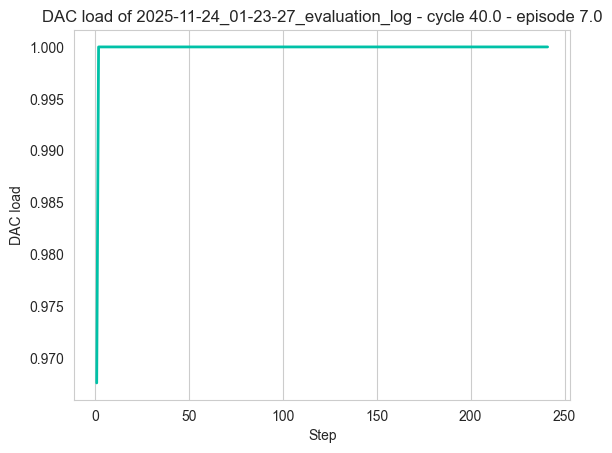

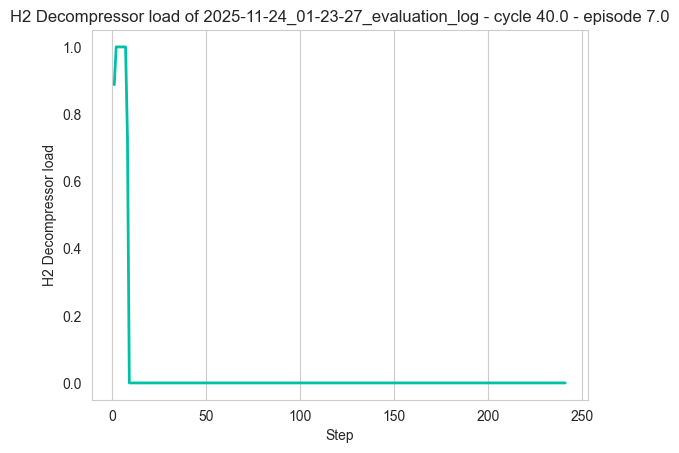

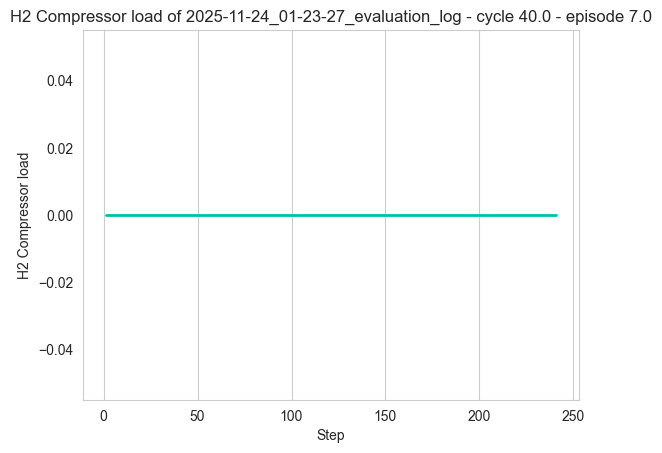

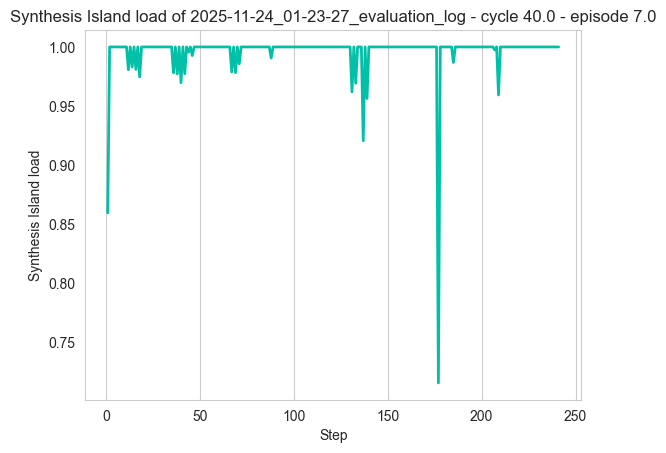

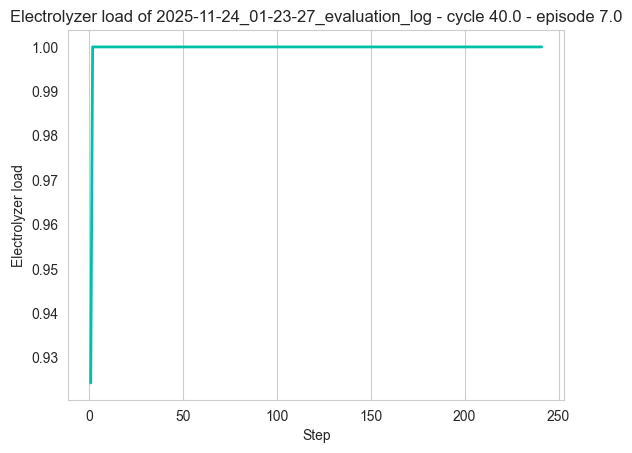

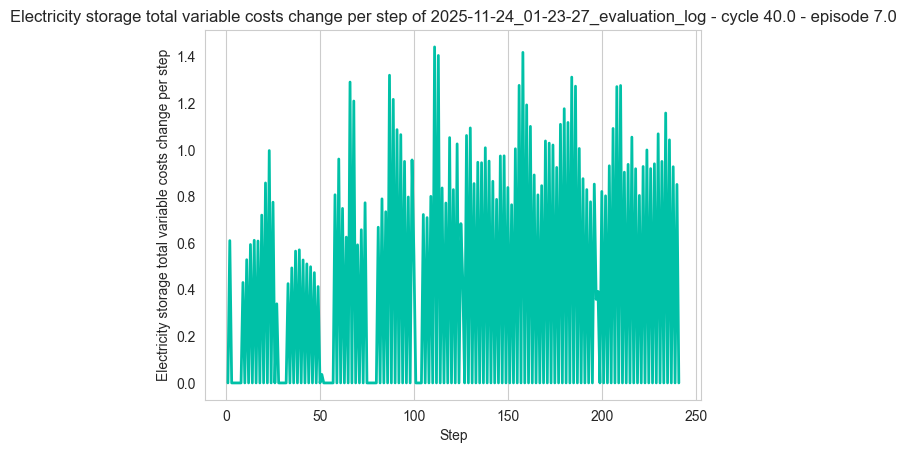

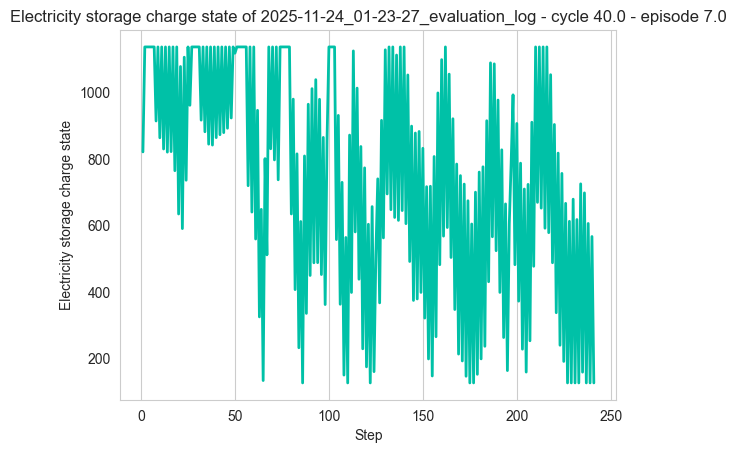

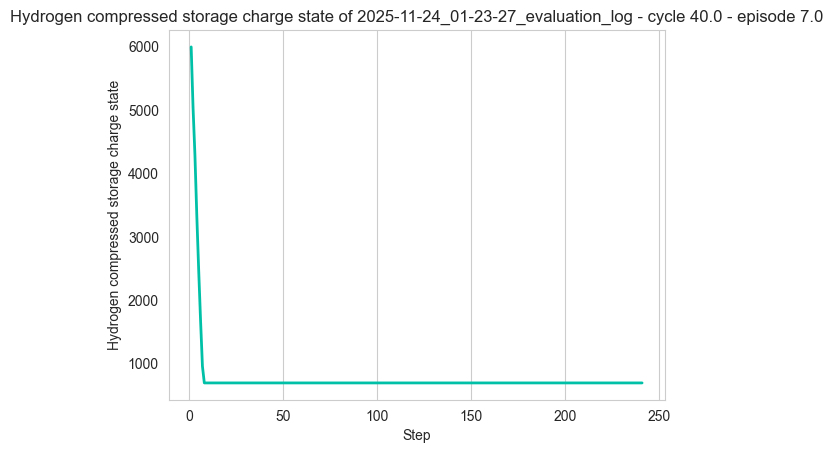

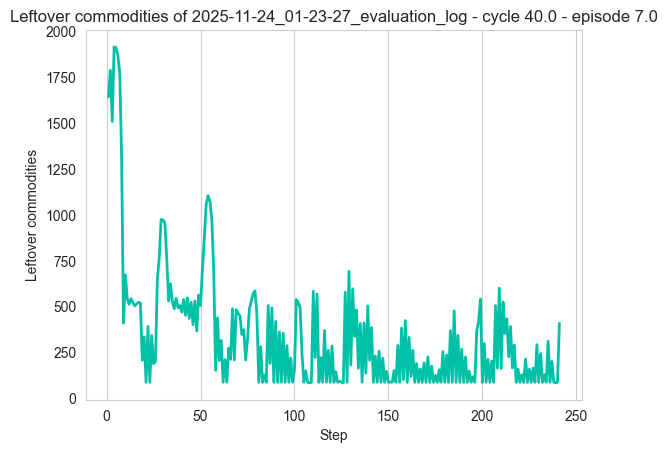

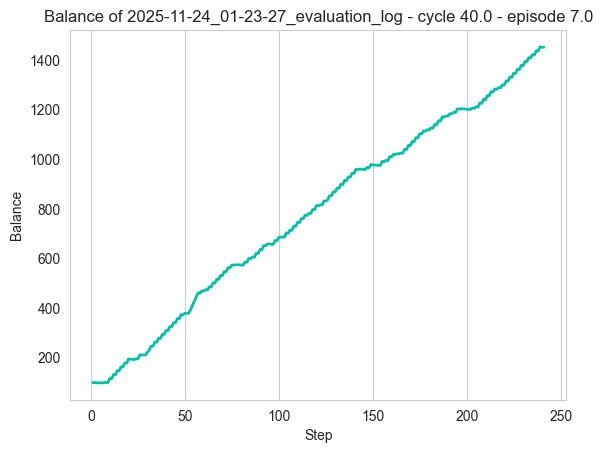

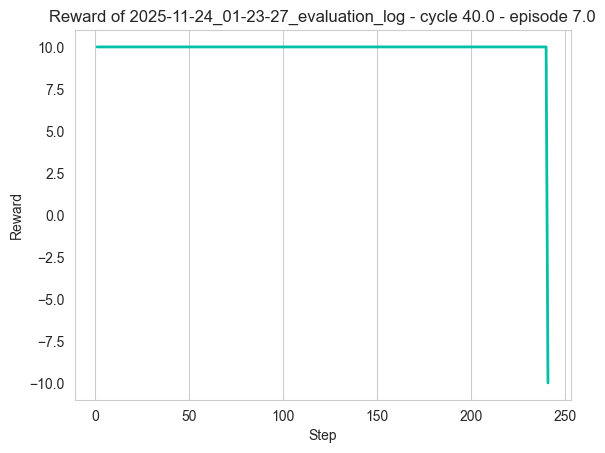

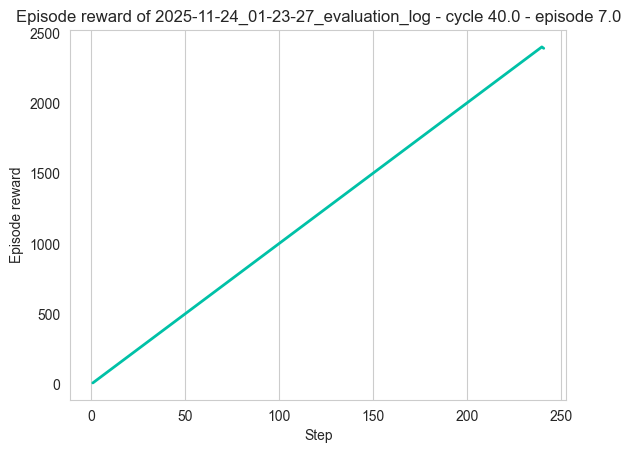

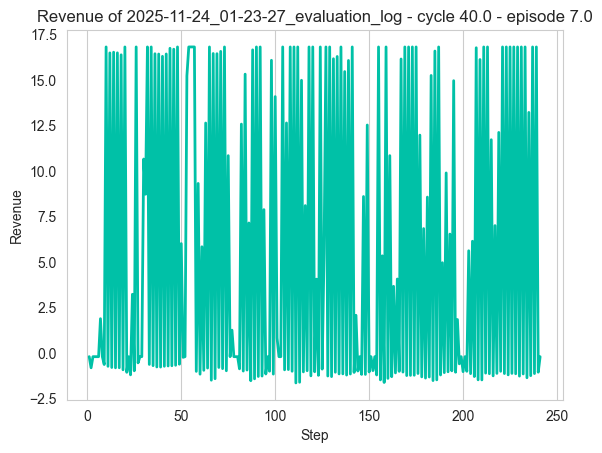

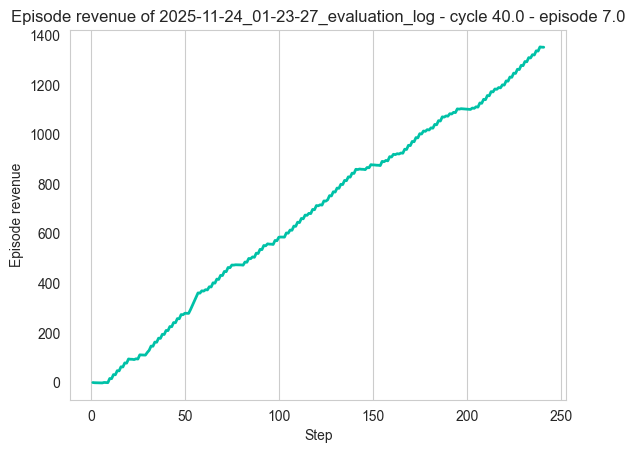

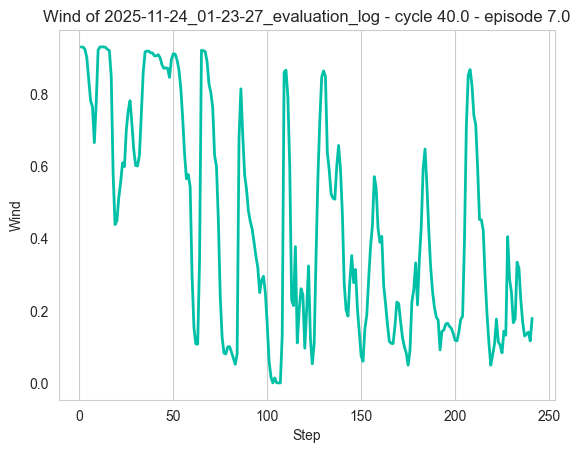

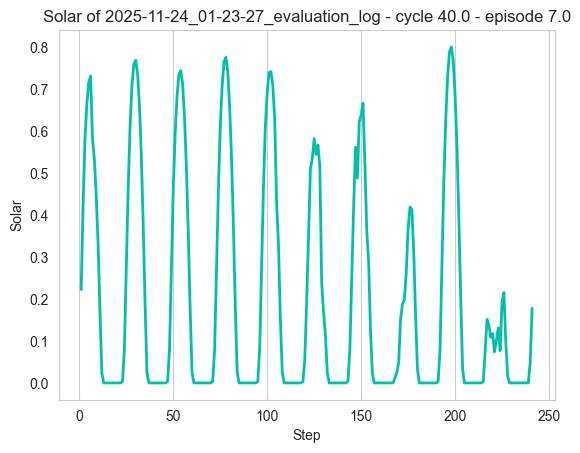

In [16]:
# Plot detailed statistics for best episode of test phase 1
plot_log(type="evaluation", cycle=[40], episode=[7], filename="2025-11-24_01-23-27_evaluation_log")

Creating 31 plots for 1 cycle with each 1 episodes with 31 variables...


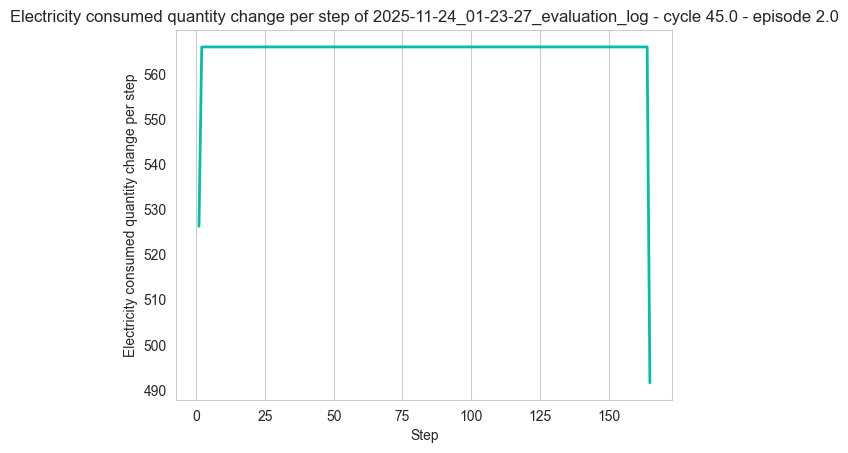

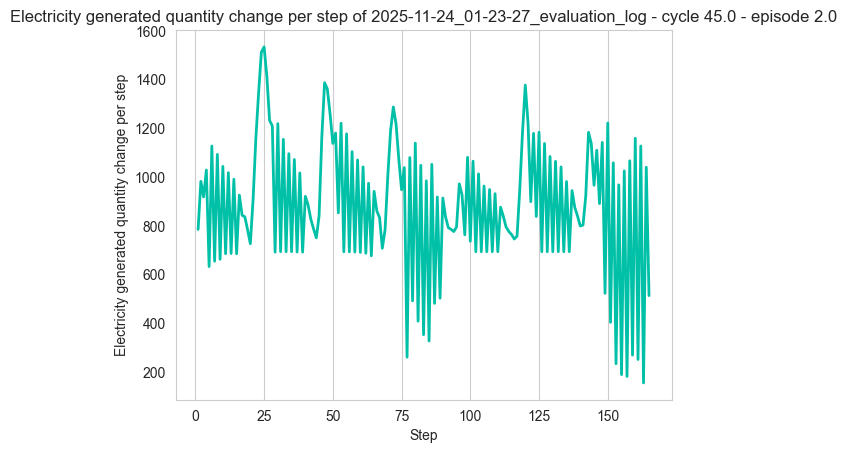

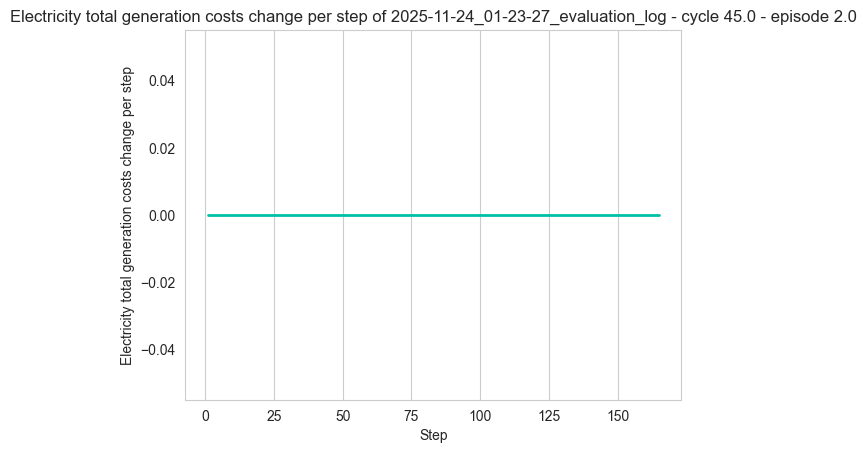

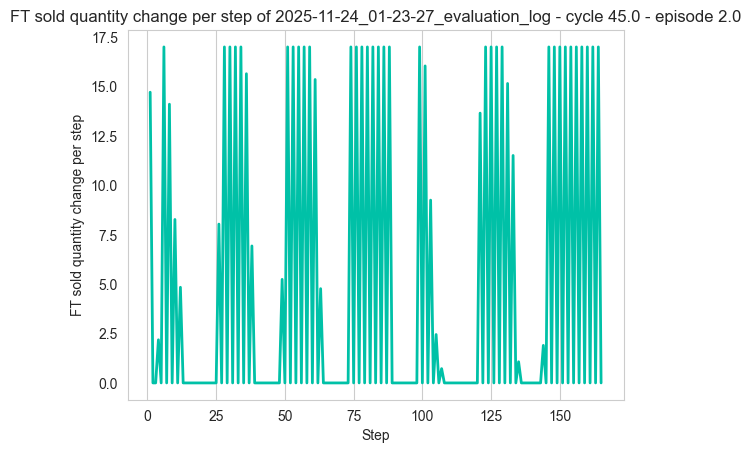

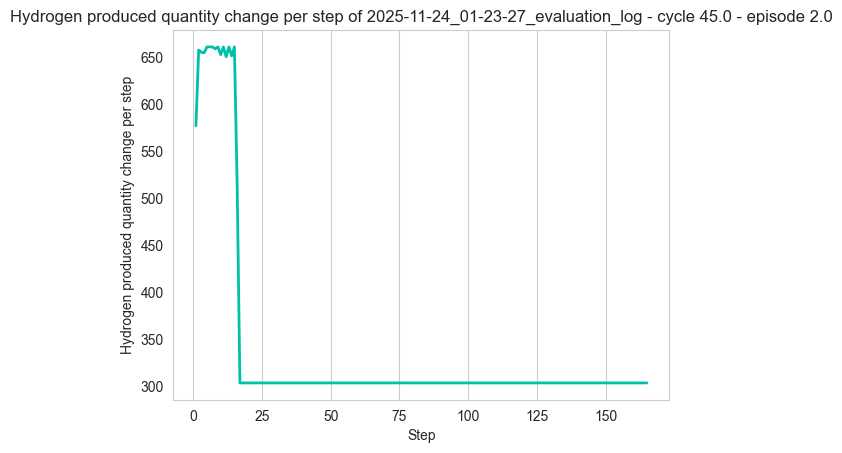

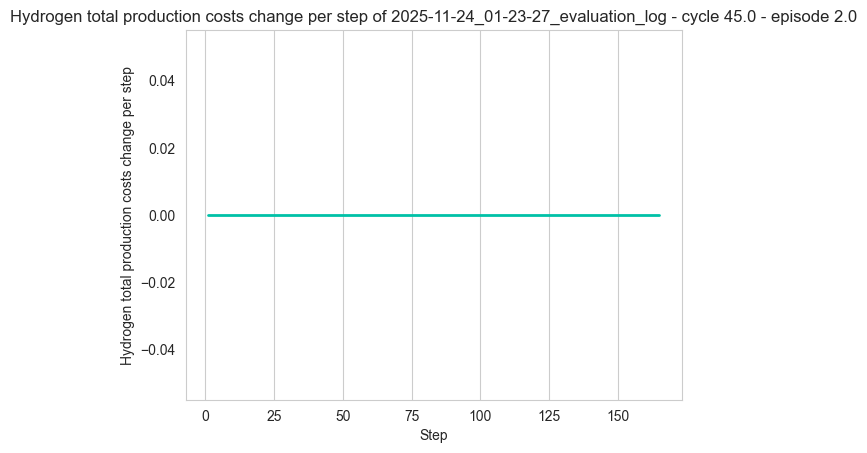

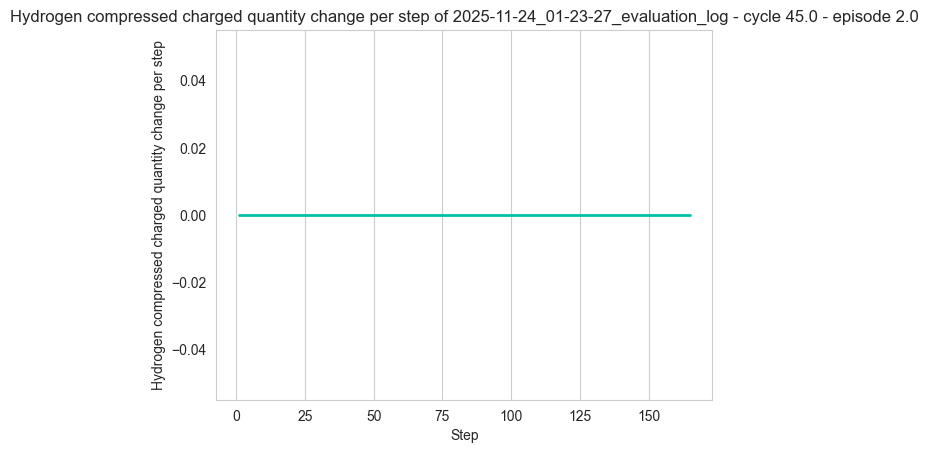

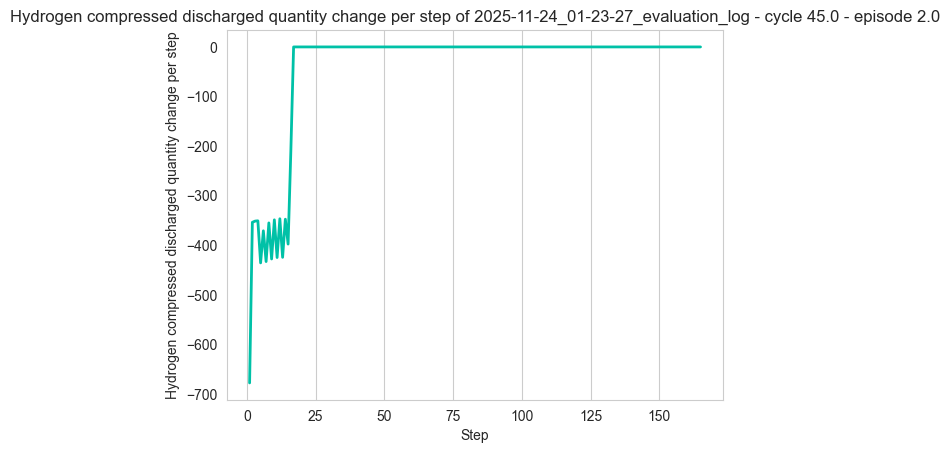

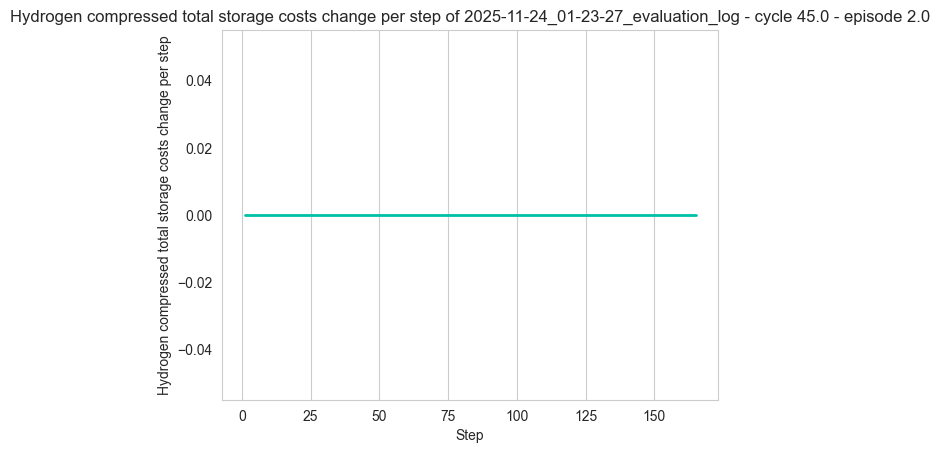

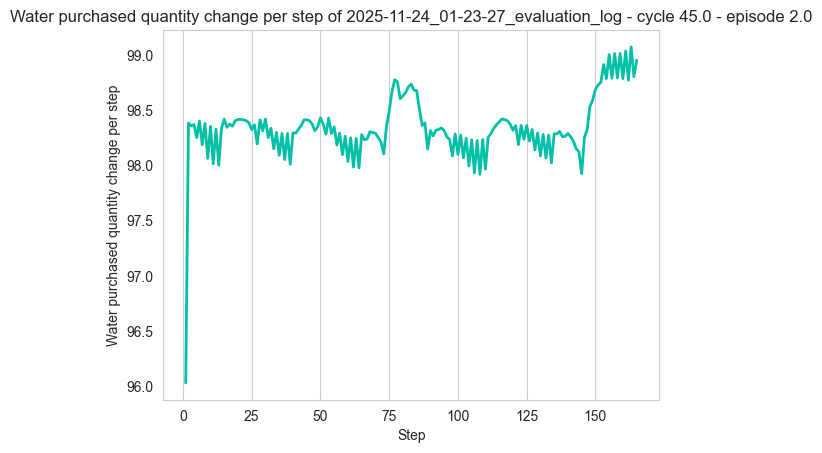

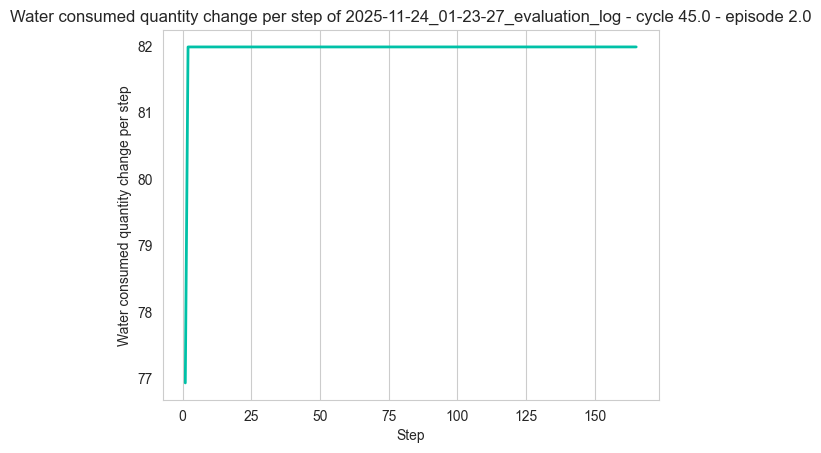

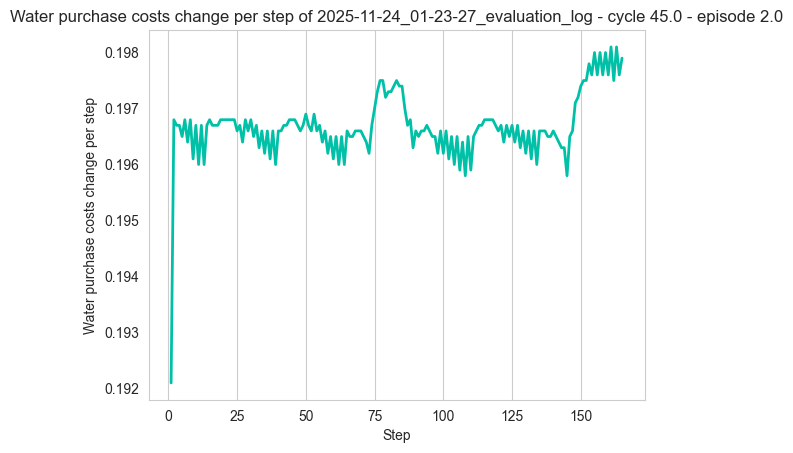

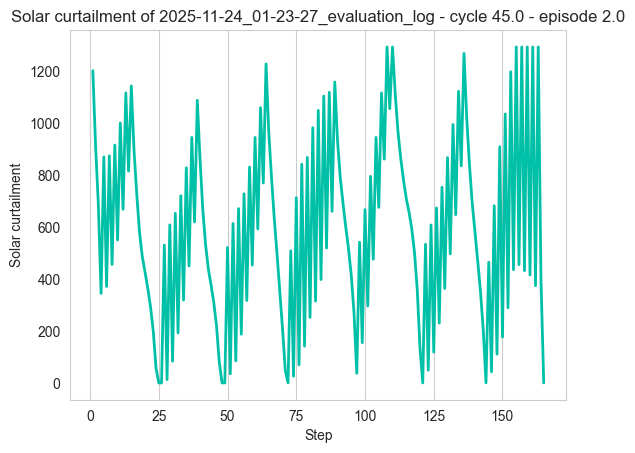

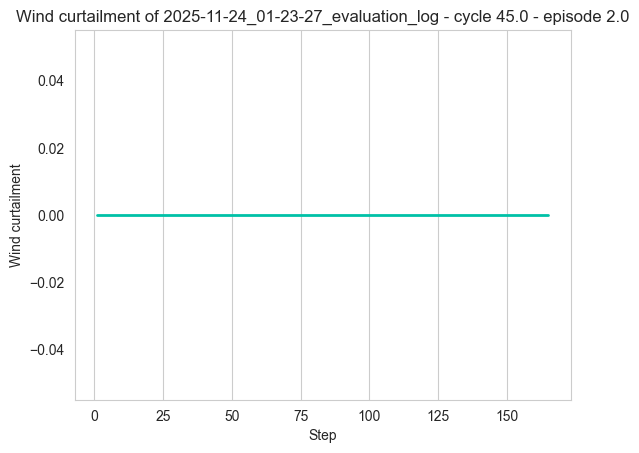

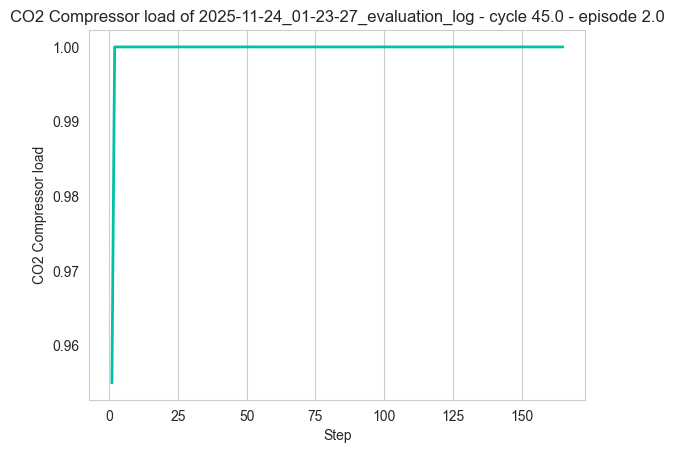

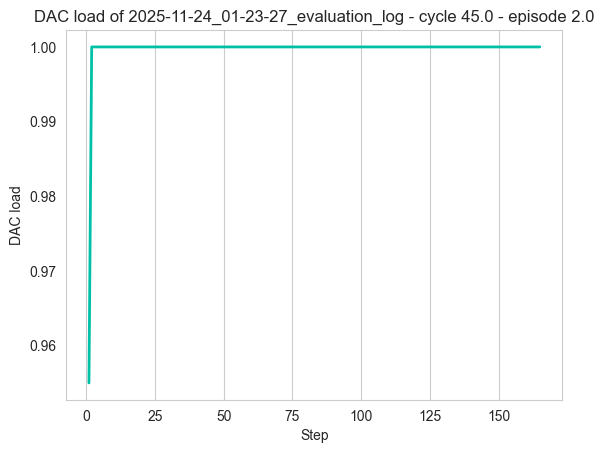

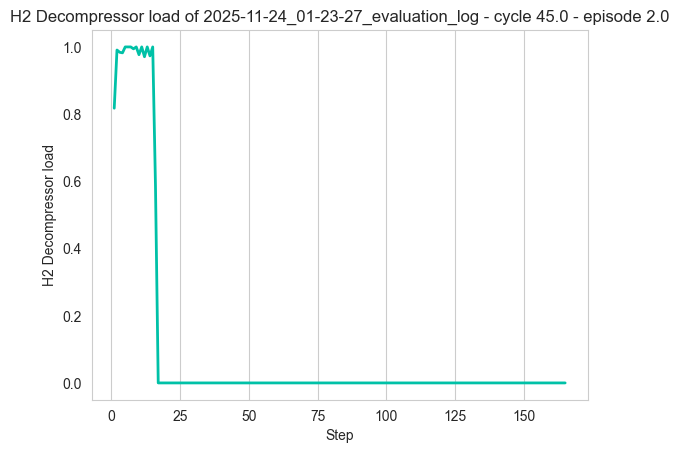

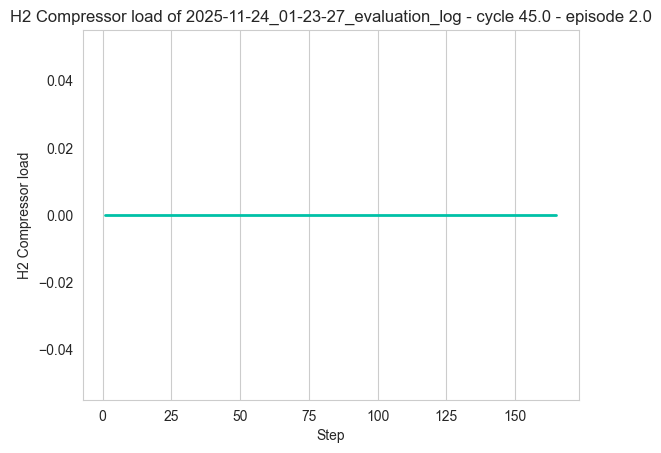

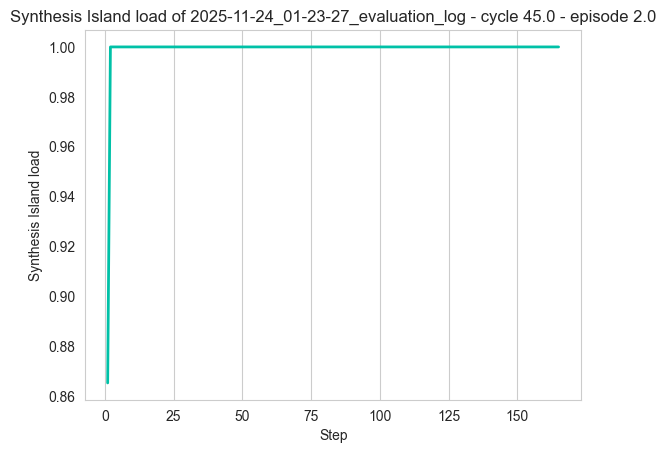

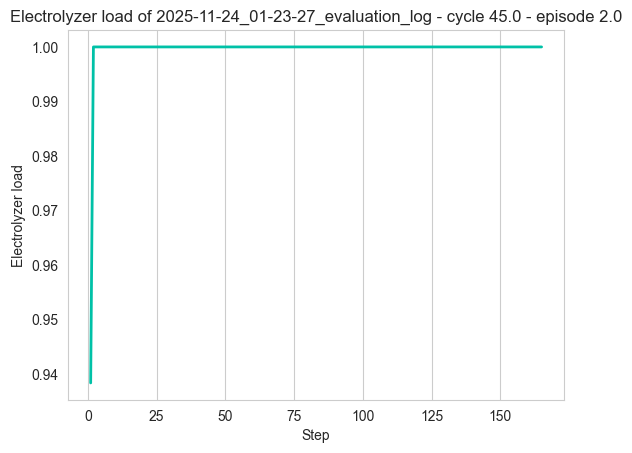

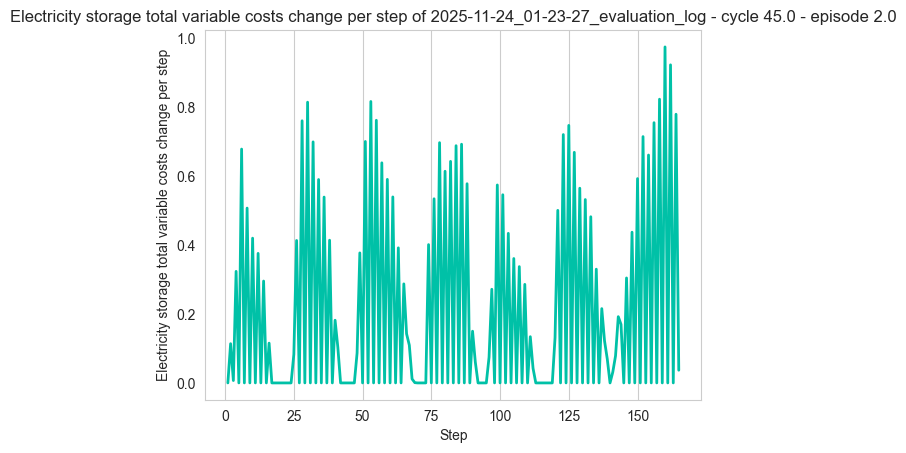

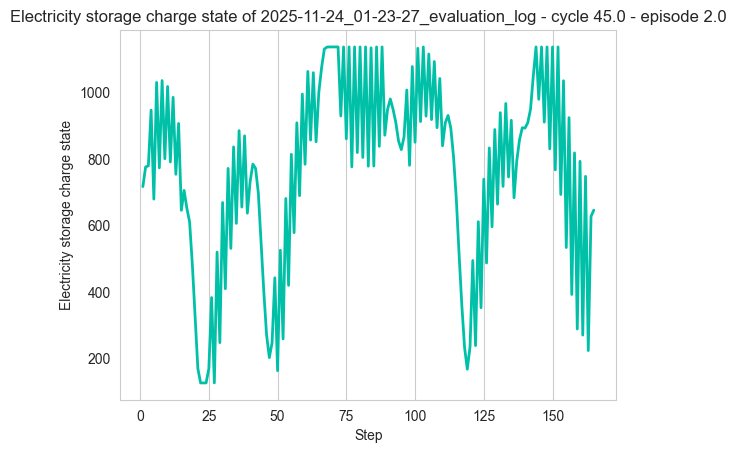

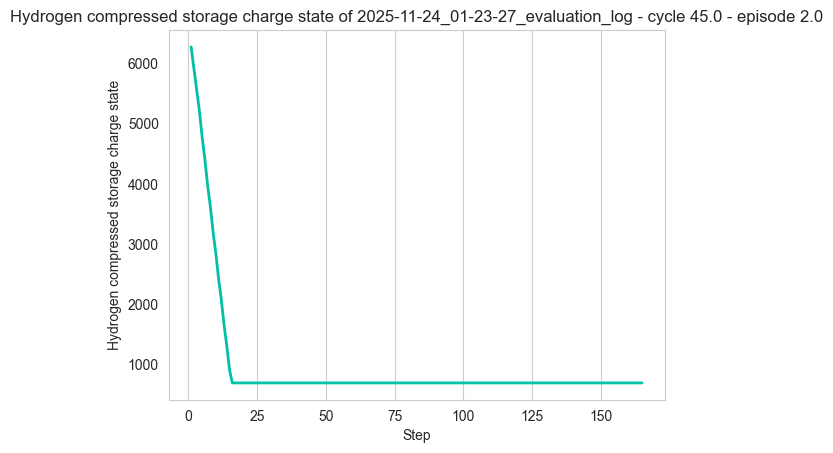

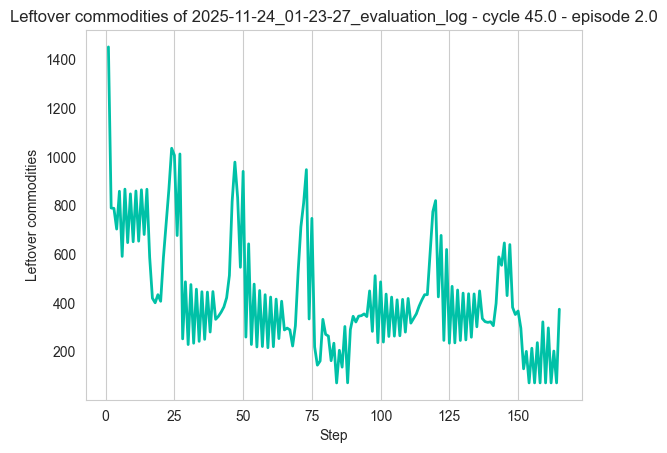

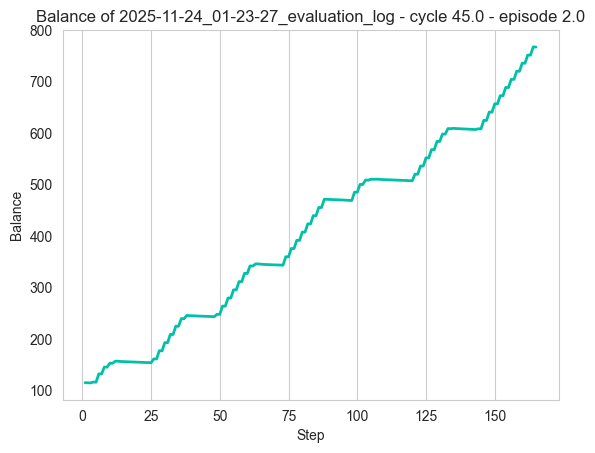

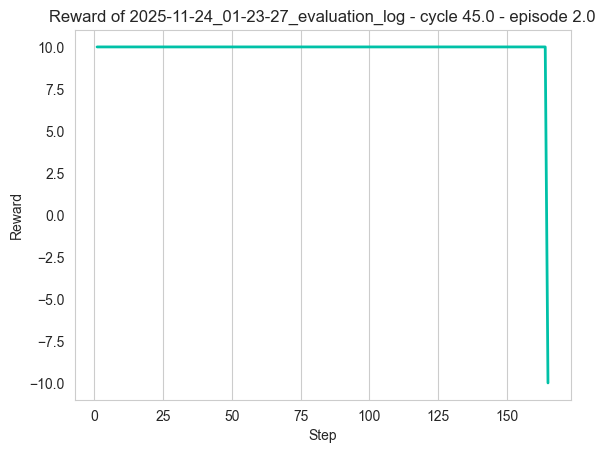

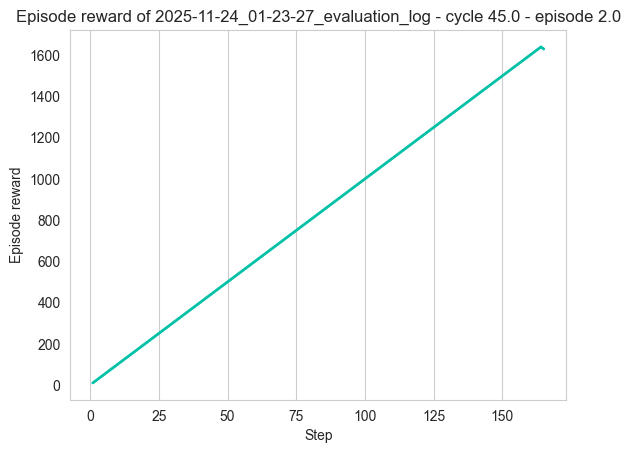

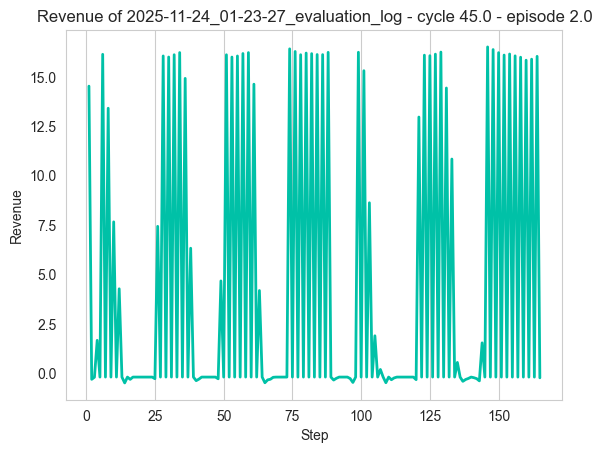

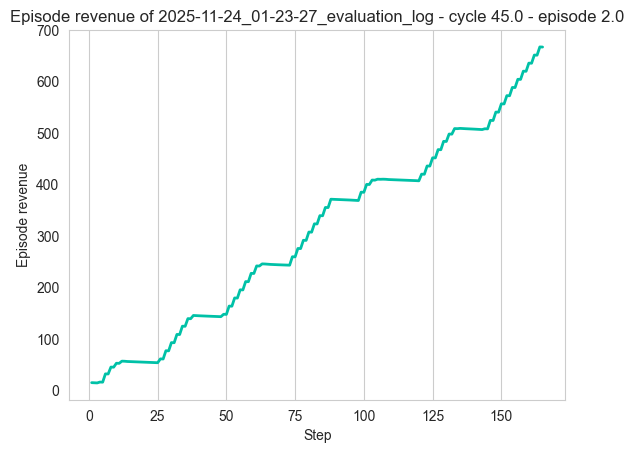

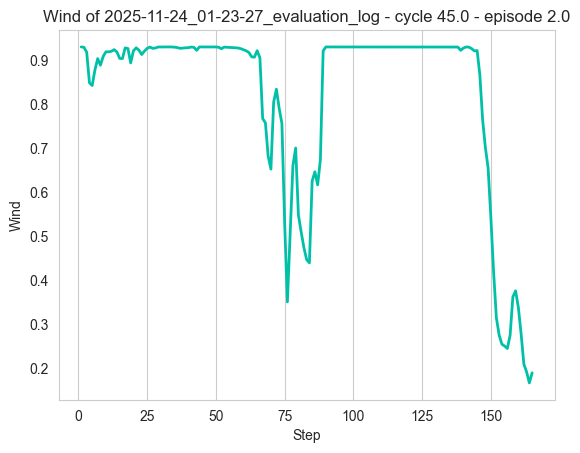

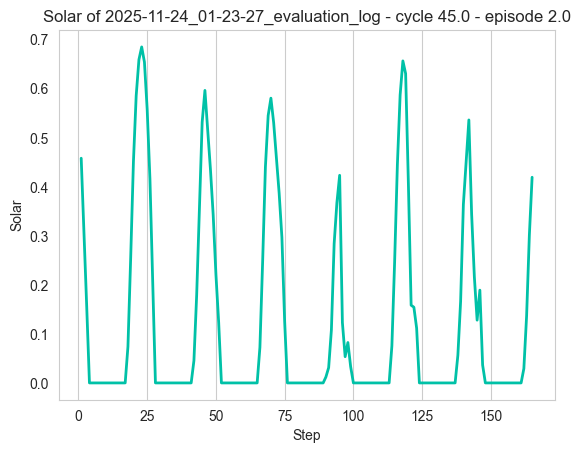

In [17]:
# Plot detailed statistics for best episode of test phase 2
plot_log(type="evaluation", cycle=[45], episode=[2], filename="2025-11-24_01-23-27_evaluation_log")

Creating 31 plots for 1 cycle with each 1 episodes with 31 variables...


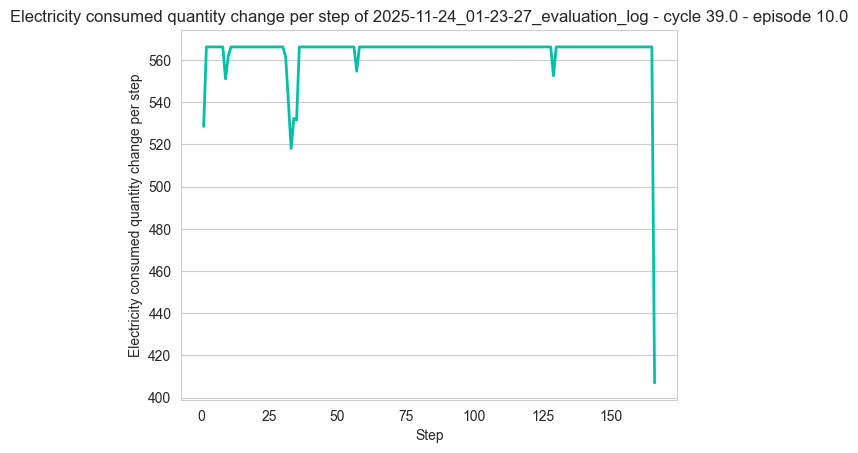

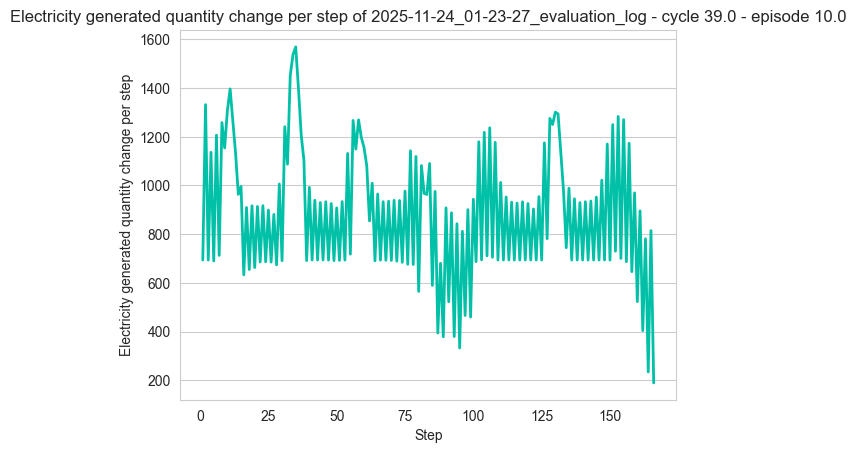

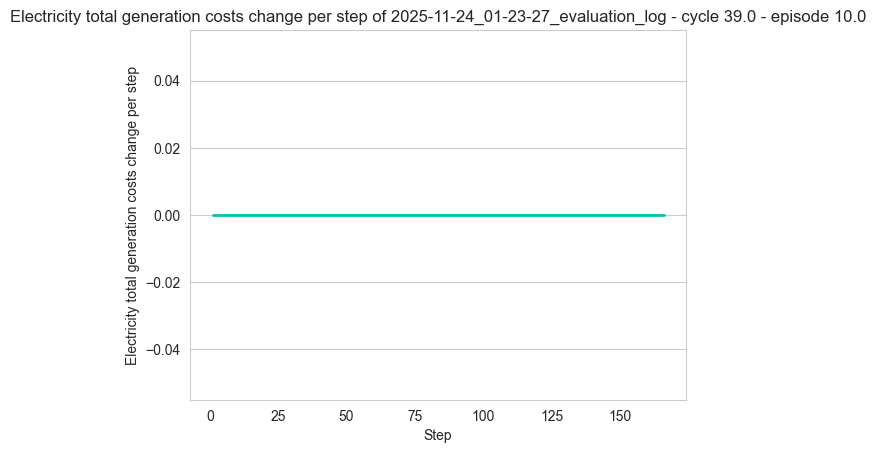

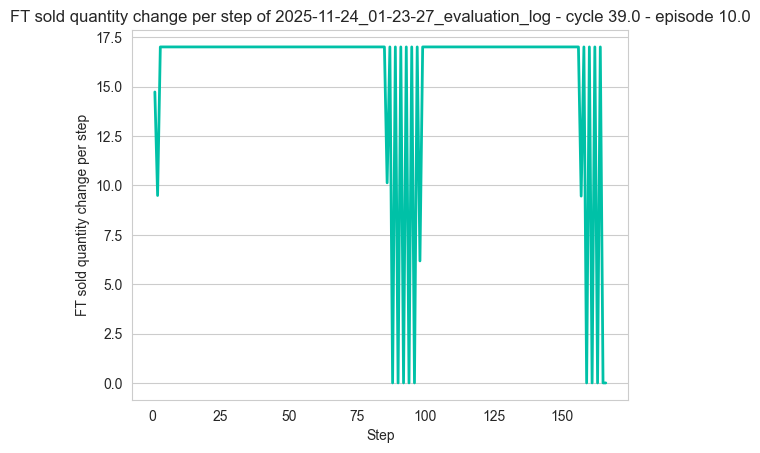

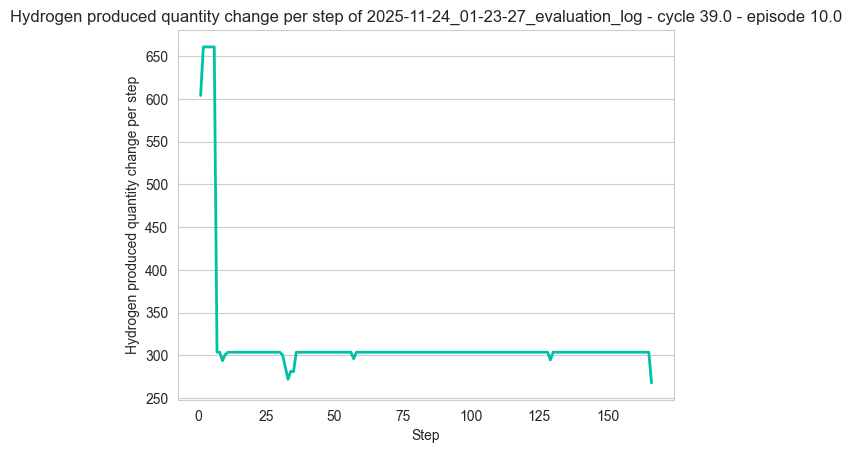

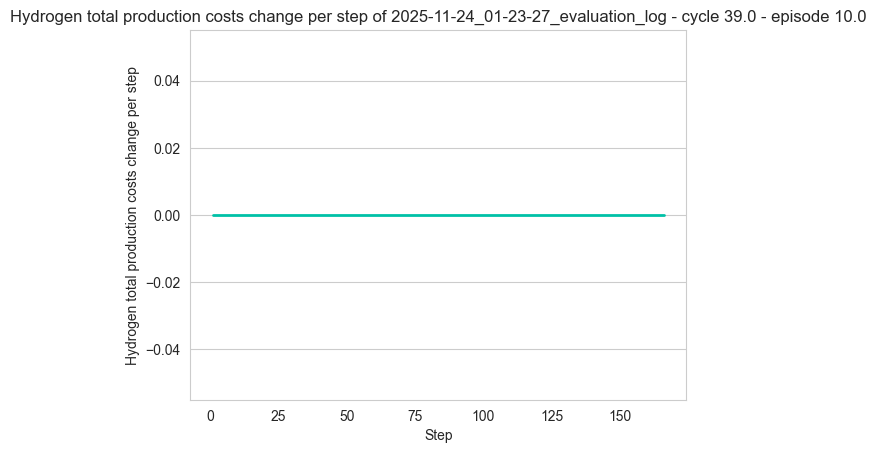

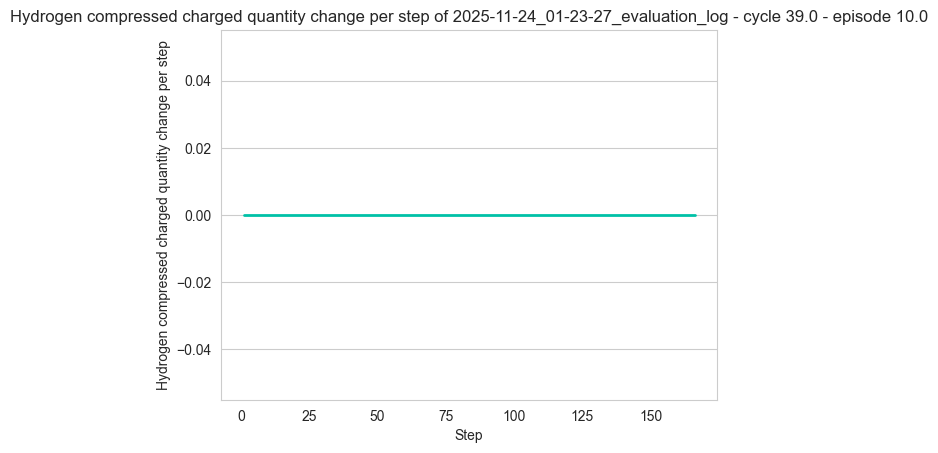

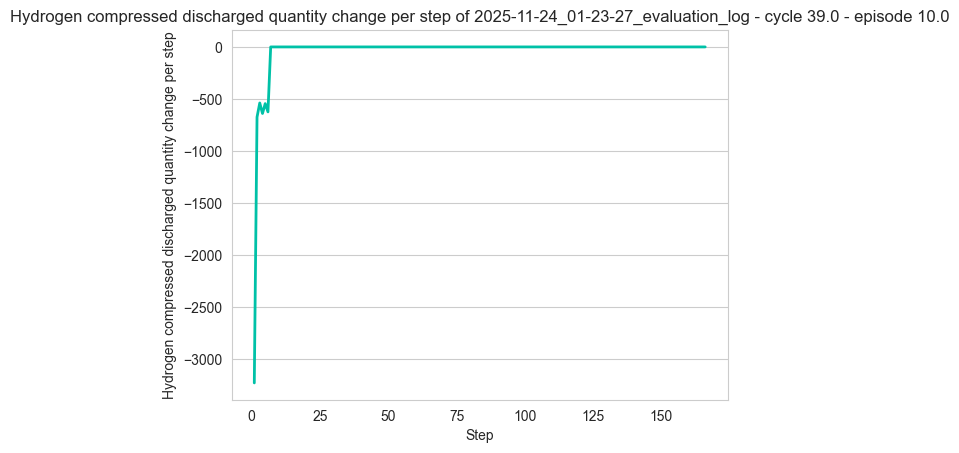

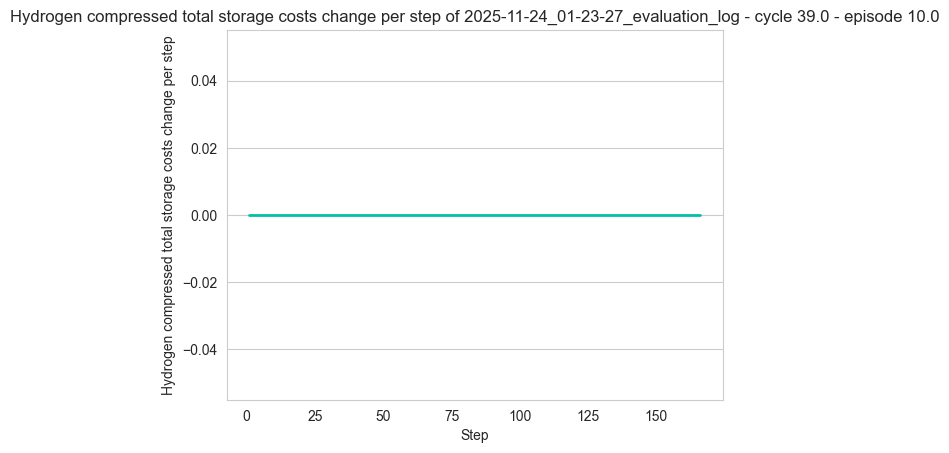

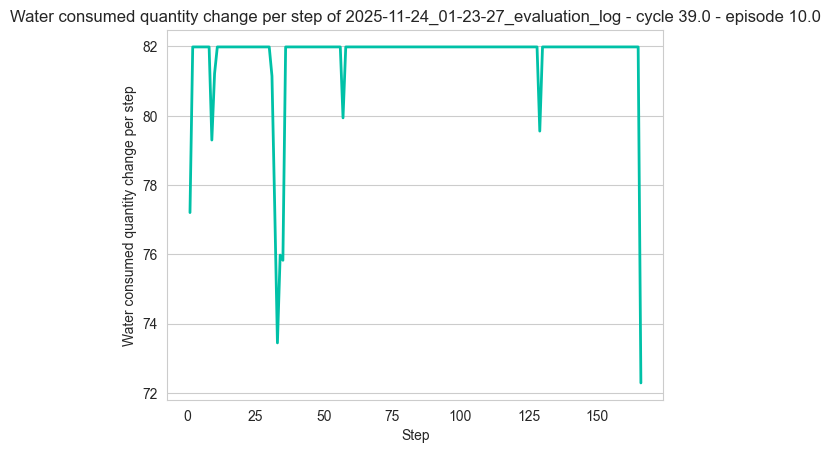

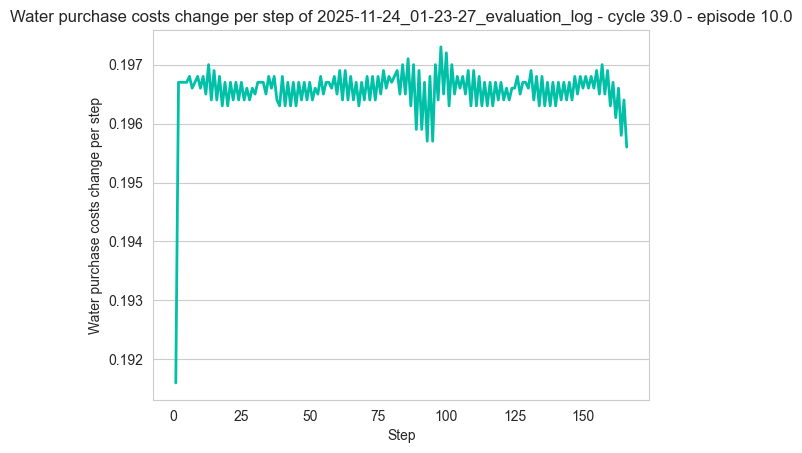

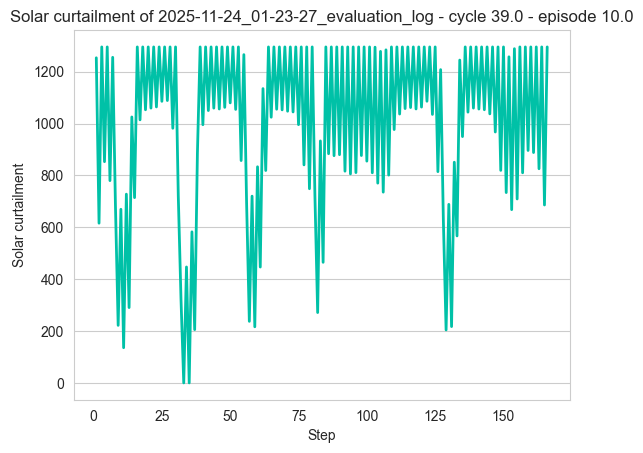

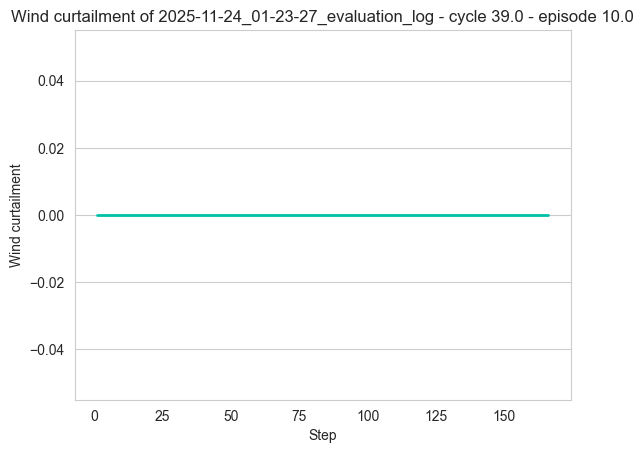

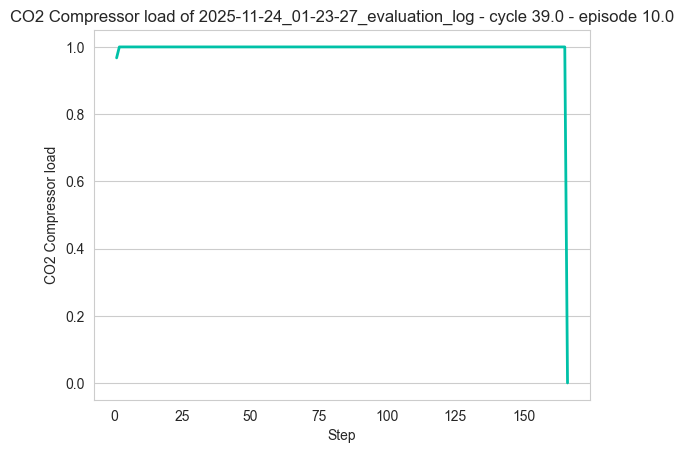

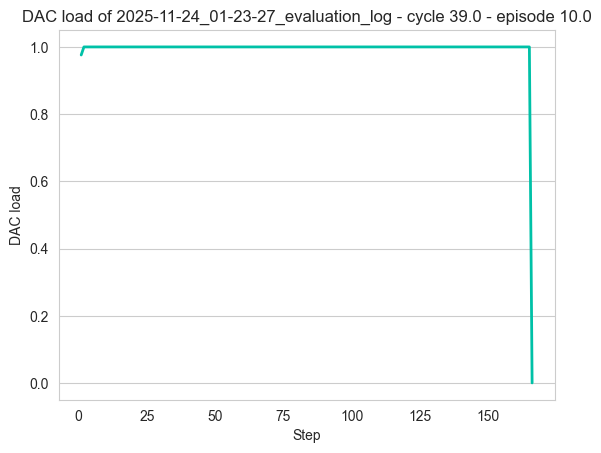

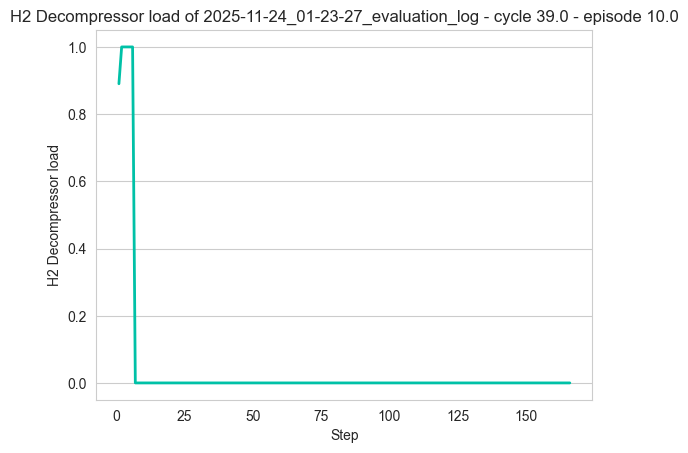

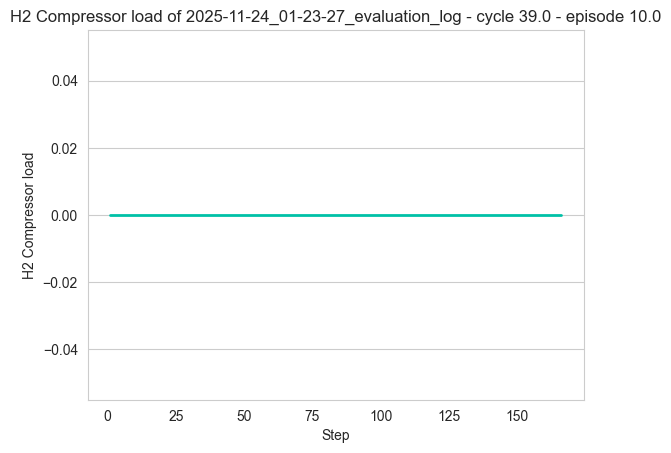

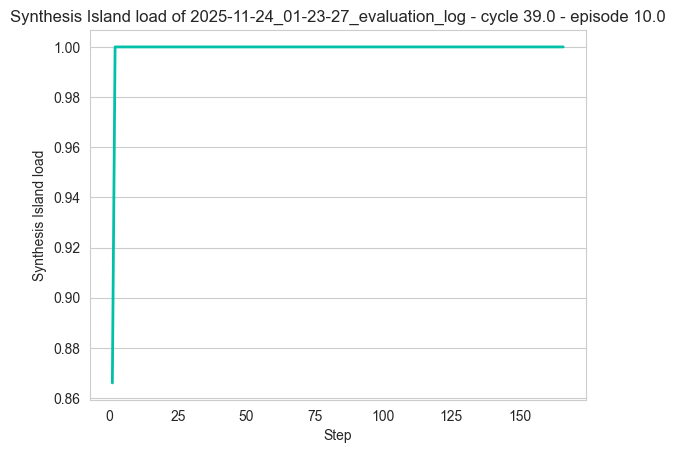

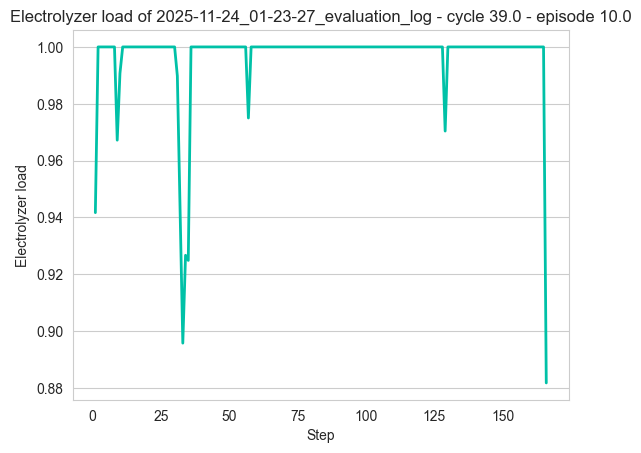

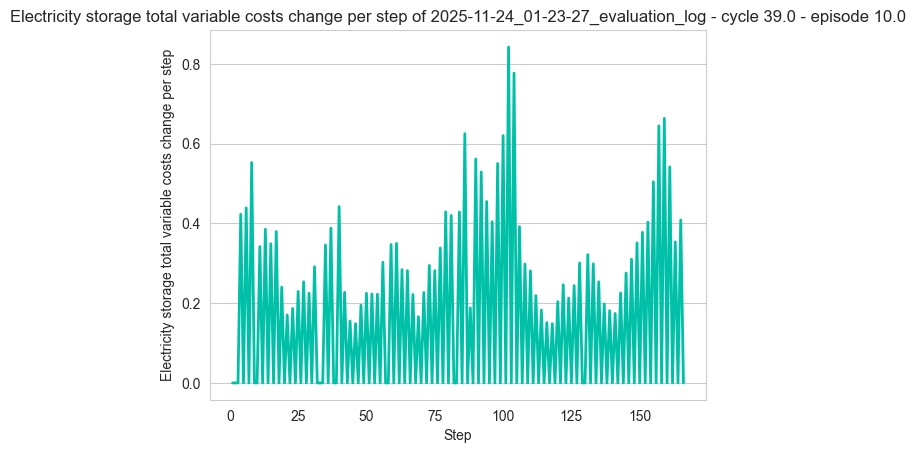

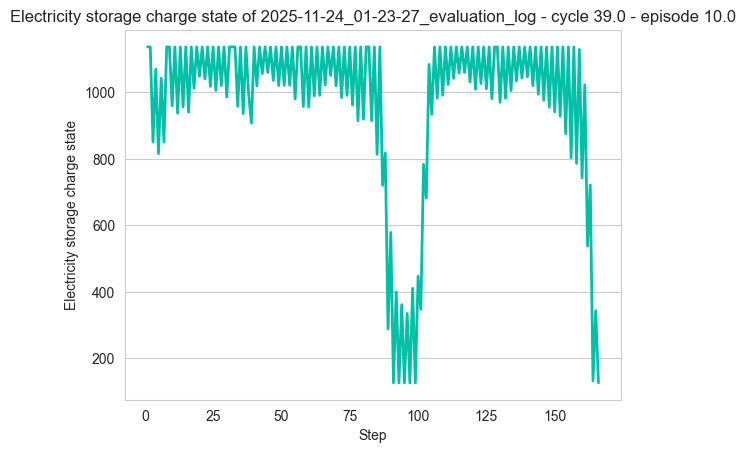

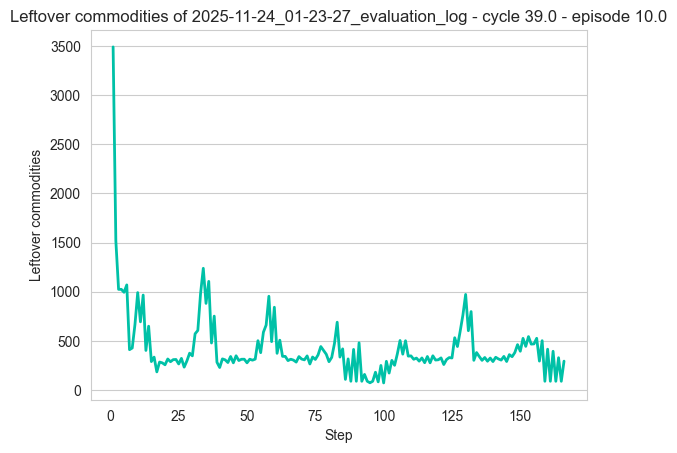

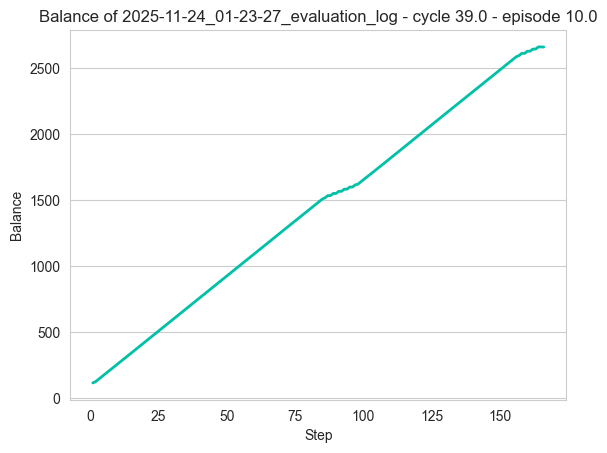

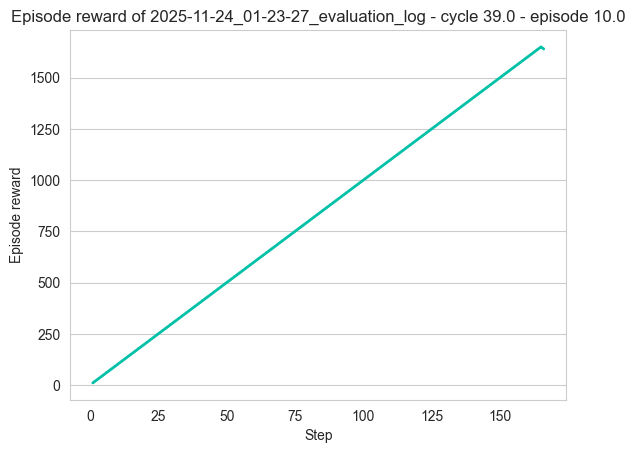

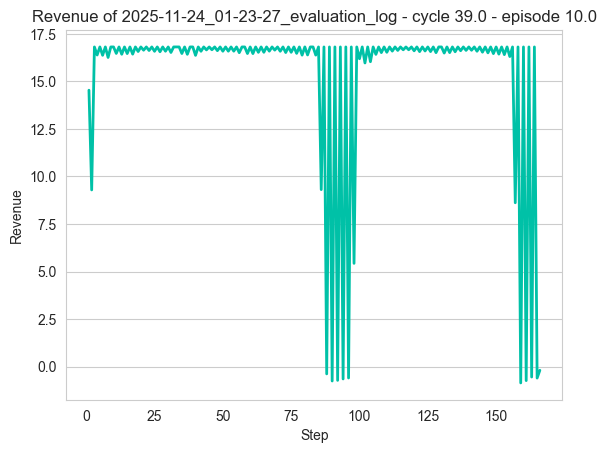

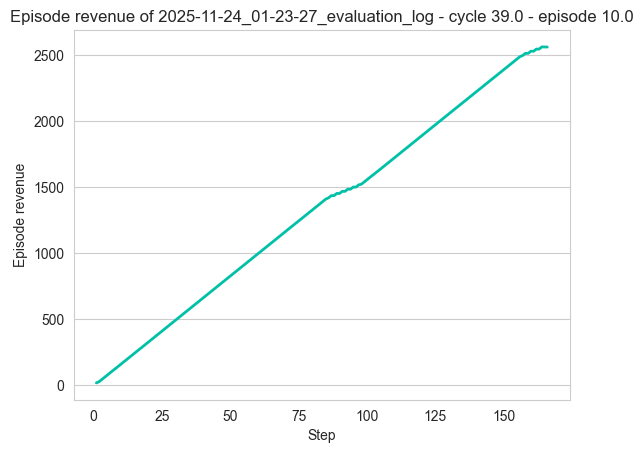

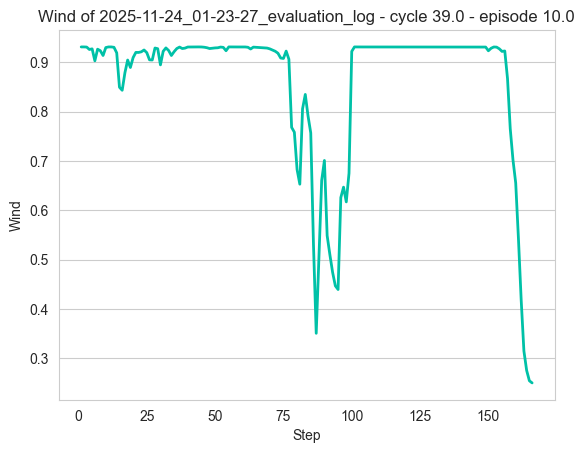

In [8]:
# Plot detailed statistics for highest revenue episode
plot_log(type="evaluation", cycle=[39], episode=[10], filename="2025-11-24_01-23-27_evaluation_log")